# Sciplex Dose

In [1]:
ood_seed = 0

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('BMS', '5.0'), 193)

Removed datapoint: 193


In [10]:
adata

AnnData object with n_obs × n_vars = 14618 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_ood-seed_expression-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1713,1569,1423,1741,1288,1555,1423,983
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1403,3557,2216,2806,1713
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 442,392,369,430,309,385,344,252
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 343,911,544,683,442
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:09<1:33:10,  9.33s/it]

Epoch 1/600:   0%|          | 1/600 [00:09<1:33:10,  9.33s/it, v_num=1, total_loss_train=2.66e+3, kl_local_train=40.3]

Epoch 2/600:   0%|          | 1/600 [00:09<1:33:10,  9.33s/it, v_num=1, total_loss_train=2.66e+3, kl_local_train=40.3]

Epoch 2/600:   0%|          | 2/600 [00:18<1:31:04,  9.14s/it, v_num=1, total_loss_train=2.66e+3, kl_local_train=40.3]

Epoch 2/600:   0%|          | 2/600 [00:18<1:31:04,  9.14s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=70.5]

Epoch 3/600:   0%|          | 2/600 [00:18<1:31:04,  9.14s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=70.5]

Epoch 3/600:   0%|          | 3/600 [00:27<1:29:24,  8.98s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=70.5]

Epoch 3/600:   0%|          | 3/600 [00:27<1:29:24,  8.98s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=74.3]

Epoch 4/600:   0%|          | 3/600 [00:27<1:29:24,  8.98s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=74.3]

Epoch 4/600:   1%|          | 4/600 [00:35<1:27:52,  8.85s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=74.3]

Epoch 4/600:   1%|          | 4/600 [00:35<1:27:52,  8.85s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=65.5]

Epoch 5/600:   1%|          | 4/600 [00:35<1:27:52,  8.85s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=65.5]

Epoch 5/600:   1%|          | 5/600 [00:44<1:26:36,  8.73s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=65.5]

Epoch 5/600:   1%|          | 5/600 [00:44<1:26:36,  8.73s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=53]  

Epoch 6/600:   1%|          | 5/600 [00:44<1:26:36,  8.73s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=53]

Epoch 6/600:   1%|          | 6/600 [00:53<1:26:39,  8.75s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=53]

Epoch 6/600:   1%|          | 6/600 [00:53<1:26:39,  8.75s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 7/600:   1%|          | 6/600 [00:53<1:26:39,  8.75s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 7/600:   1%|          | 7/600 [01:01<1:24:39,  8.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 7/600:   1%|          | 7/600 [01:01<1:24:39,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 8/600:   1%|          | 7/600 [01:01<1:24:39,  8.57s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 8/600:   1%|▏         | 8/600 [01:09<1:22:24,  8.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 8/600:   1%|▏         | 8/600 [01:09<1:22:24,  8.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 9/600:   1%|▏         | 8/600 [01:09<1:22:24,  8.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 9/600:   2%|▏         | 9/600 [01:17<1:21:39,  8.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 9/600:   2%|▏         | 9/600 [01:17<1:21:39,  8.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 10/600:   2%|▏         | 9/600 [01:17<1:21:39,  8.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 10/600:   2%|▏         | 10/600 [01:25<1:20:57,  8.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 10/600:   2%|▏         | 10/600 [01:25<1:20:57,  8.23s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 11/600:   2%|▏         | 10/600 [01:26<1:20:57,  8.23s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 11/600:   2%|▏         | 11/600 [01:34<1:22:20,  8.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0527, metric_mi|condition_train=0.117]

Epoch 11/600:   2%|▏         | 11/600 [01:34<1:22:20,  8.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 12/600:   2%|▏         | 11/600 [01:34<1:22:20,  8.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 12/600:   2%|▏         | 12/600 [01:42<1:21:19,  8.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 12/600:   2%|▏         | 12/600 [01:42<1:21:19,  8.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 13/600:   2%|▏         | 12/600 [01:42<1:21:19,  8.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 13/600:   2%|▏         | 13/600 [01:49<1:19:29,  8.13s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 13/600:   2%|▏         | 13/600 [01:49<1:19:29,  8.13s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 14/600:   2%|▏         | 13/600 [01:50<1:19:29,  8.13s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 14/600:   2%|▏         | 14/600 [01:58<1:19:10,  8.11s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 14/600:   2%|▏         | 14/600 [01:58<1:19:10,  8.11s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=91, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]  

Epoch 15/600:   2%|▏         | 14/600 [01:58<1:19:10,  8.11s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=91, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 15/600:   2%|▎         | 15/600 [02:06<1:18:35,  8.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=91, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 15/600:   2%|▎         | 15/600 [02:06<1:18:35,  8.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=103, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 16/600:   2%|▎         | 15/600 [02:06<1:18:35,  8.06s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=103, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 16/600:   3%|▎         | 16/600 [02:14<1:19:44,  8.19s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=103, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.168]

Epoch 16/600:   3%|▎         | 16/600 [02:14<1:19:44,  8.19s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=116, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 17/600:   3%|▎         | 16/600 [02:14<1:19:44,  8.19s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=116, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 17/600:   3%|▎         | 17/600 [02:23<1:22:45,  8.52s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=116, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 17/600:   3%|▎         | 17/600 [02:23<1:22:45,  8.52s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 18/600:   3%|▎         | 17/600 [02:23<1:22:45,  8.52s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 18/600:   3%|▎         | 18/600 [02:33<1:24:41,  8.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 18/600:   3%|▎         | 18/600 [02:33<1:24:41,  8.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 19/600:   3%|▎         | 18/600 [02:33<1:24:41,  8.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 19/600:   3%|▎         | 19/600 [02:41<1:25:15,  8.80s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 19/600:   3%|▎         | 19/600 [02:41<1:25:15,  8.80s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=175, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 20/600:   3%|▎         | 19/600 [02:41<1:25:15,  8.80s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=175, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 20/600:   3%|▎         | 20/600 [02:51<1:27:14,  9.02s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=175, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 20/600:   3%|▎         | 20/600 [02:51<1:27:14,  9.02s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=192, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 21/600:   3%|▎         | 20/600 [02:52<1:27:14,  9.02s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=192, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 21/600:   4%|▎         | 21/600 [03:01<1:29:30,  9.27s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=192, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.157]

Epoch 21/600:   4%|▎         | 21/600 [03:01<1:29:30,  9.27s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=210, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196] 

Epoch 22/600:   4%|▎         | 21/600 [03:01<1:29:30,  9.27s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=210, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 22/600:   4%|▎         | 22/600 [03:10<1:29:16,  9.27s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=210, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 22/600:   4%|▎         | 22/600 [03:10<1:29:16,  9.27s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=220, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 23/600:   4%|▎         | 22/600 [03:10<1:29:16,  9.27s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=220, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 23/600:   4%|▍         | 23/600 [03:19<1:28:08,  9.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=220, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 23/600:   4%|▍         | 23/600 [03:19<1:28:08,  9.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=235, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 24/600:   4%|▍         | 23/600 [03:19<1:28:08,  9.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=235, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 24/600:   4%|▍         | 24/600 [03:28<1:28:20,  9.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=235, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 24/600:   4%|▍         | 24/600 [03:28<1:28:20,  9.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=255, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 25/600:   4%|▍         | 24/600 [03:28<1:28:20,  9.20s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=255, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 25/600:   4%|▍         | 25/600 [03:38<1:29:02,  9.29s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=255, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 25/600:   4%|▍         | 25/600 [03:38<1:29:02,  9.29s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=266, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 26/600:   4%|▍         | 25/600 [03:38<1:29:02,  9.29s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=266, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 26/600:   4%|▍         | 26/600 [03:48<1:30:28,  9.46s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=266, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.196]

Epoch 26/600:   4%|▍         | 26/600 [03:48<1:30:28,  9.46s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=279, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]  

Epoch 27/600:   4%|▍         | 26/600 [03:48<1:30:28,  9.46s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=279, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 27/600:   4%|▍         | 27/600 [03:57<1:28:47,  9.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=279, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 27/600:   4%|▍         | 27/600 [03:57<1:28:47,  9.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=285, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 28/600:   4%|▍         | 27/600 [03:57<1:28:47,  9.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=285, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 28/600:   5%|▍         | 28/600 [04:06<1:28:19,  9.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=285, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 28/600:   5%|▍         | 28/600 [04:06<1:28:19,  9.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=278, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 29/600:   5%|▍         | 28/600 [04:06<1:28:19,  9.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=278, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 29/600:   5%|▍         | 29/600 [04:15<1:28:05,  9.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=278, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 29/600:   5%|▍         | 29/600 [04:15<1:28:05,  9.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=289, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 30/600:   5%|▍         | 29/600 [04:15<1:28:05,  9.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=289, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 30/600:   5%|▌         | 30/600 [04:24<1:28:27,  9.31s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=289, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 30/600:   5%|▌         | 30/600 [04:24<1:28:27,  9.31s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 31/600:   5%|▌         | 30/600 [04:25<1:28:27,  9.31s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 31/600:   5%|▌         | 31/600 [04:34<1:29:01,  9.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=301, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.232]

Epoch 31/600:   5%|▌         | 31/600 [04:34<1:29:01,  9.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=286, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 32/600:   5%|▌         | 31/600 [04:34<1:29:01,  9.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=286, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 32/600:   5%|▌         | 32/600 [04:42<1:24:56,  8.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=286, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 32/600:   5%|▌         | 32/600 [04:42<1:24:56,  8.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=281, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 33/600:   5%|▌         | 32/600 [04:42<1:24:56,  8.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=281, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 33/600:   6%|▌         | 33/600 [04:50<1:22:06,  8.69s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=281, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 33/600:   6%|▌         | 33/600 [04:50<1:22:06,  8.69s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=287, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 34/600:   6%|▌         | 33/600 [04:50<1:22:06,  8.69s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=287, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 34/600:   6%|▌         | 34/600 [04:58<1:18:59,  8.37s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=287, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 34/600:   6%|▌         | 34/600 [04:58<1:18:59,  8.37s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=292, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 35/600:   6%|▌         | 34/600 [04:58<1:18:59,  8.37s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=292, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 35/600:   6%|▌         | 35/600 [05:06<1:18:52,  8.38s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=292, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 35/600:   6%|▌         | 35/600 [05:06<1:18:52,  8.38s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=291, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 36/600:   6%|▌         | 35/600 [05:07<1:18:52,  8.38s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=291, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 36/600:   6%|▌         | 36/600 [05:15<1:18:50,  8.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=291, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.25]

Epoch 36/600:   6%|▌         | 36/600 [05:15<1:18:50,  8.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=299, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 37/600:   6%|▌         | 36/600 [05:15<1:18:50,  8.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=299, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 37/600:   6%|▌         | 37/600 [05:22<1:17:09,  8.22s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=299, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 37/600:   6%|▌         | 37/600 [05:22<1:17:09,  8.22s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=292, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 38/600:   6%|▌         | 37/600 [05:22<1:17:09,  8.22s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=292, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 38/600:   6%|▋         | 38/600 [05:30<1:16:26,  8.16s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=292, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 38/600:   6%|▋         | 38/600 [05:30<1:16:26,  8.16s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=277, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251] 

Epoch 39/600:   6%|▋         | 38/600 [05:30<1:16:26,  8.16s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=277, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 39/600:   6%|▋         | 39/600 [05:38<1:14:48,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=277, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 39/600:   6%|▋         | 39/600 [05:38<1:14:48,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=282, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 40/600:   6%|▋         | 39/600 [05:38<1:14:48,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=282, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 40/600:   7%|▋         | 40/600 [05:46<1:15:12,  8.06s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=282, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 40/600:   7%|▋         | 40/600 [05:46<1:15:12,  8.06s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=279, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 41/600:   7%|▋         | 40/600 [05:47<1:15:12,  8.06s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=279, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 41/600:   7%|▋         | 41/600 [05:55<1:16:24,  8.20s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=279, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.251]

Epoch 41/600:   7%|▋         | 41/600 [05:55<1:16:24,  8.20s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=286, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25] 

Epoch 42/600:   7%|▋         | 41/600 [05:55<1:16:24,  8.20s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=286, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 42/600:   7%|▋         | 42/600 [06:02<1:14:42,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=286, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 42/600:   7%|▋         | 42/600 [06:02<1:14:42,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=274, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 43/600:   7%|▋         | 42/600 [06:02<1:14:42,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=274, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 43/600:   7%|▋         | 43/600 [06:10<1:14:31,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=274, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 43/600:   7%|▋         | 43/600 [06:10<1:14:31,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=270, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 44/600:   7%|▋         | 43/600 [06:10<1:14:31,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=270, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 44/600:   7%|▋         | 44/600 [06:18<1:14:14,  8.01s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=270, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 44/600:   7%|▋         | 44/600 [06:18<1:14:14,  8.01s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=270, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 45/600:   7%|▋         | 44/600 [06:18<1:14:14,  8.01s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=270, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 45/600:   8%|▊         | 45/600 [06:26<1:13:40,  7.96s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=270, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 45/600:   8%|▊         | 45/600 [06:26<1:13:40,  7.96s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=268, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 46/600:   8%|▊         | 45/600 [06:27<1:13:40,  7.96s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=268, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 46/600:   8%|▊         | 46/600 [06:35<1:15:19,  8.16s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=268, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 46/600:   8%|▊         | 46/600 [06:35<1:15:19,  8.16s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=264, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 47/600:   8%|▊         | 46/600 [06:35<1:15:19,  8.16s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=264, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 47/600:   8%|▊         | 47/600 [06:42<1:13:45,  8.00s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=264, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 47/600:   8%|▊         | 47/600 [06:42<1:13:45,  8.00s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=253, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 48/600:   8%|▊         | 47/600 [06:42<1:13:45,  8.00s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=253, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 48/600:   8%|▊         | 48/600 [06:50<1:13:36,  8.00s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=253, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 48/600:   8%|▊         | 48/600 [06:50<1:13:36,  8.00s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=260, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 49/600:   8%|▊         | 48/600 [06:50<1:13:36,  8.00s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=260, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 49/600:   8%|▊         | 49/600 [06:58<1:13:31,  8.01s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=260, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 49/600:   8%|▊         | 49/600 [06:58<1:13:31,  8.01s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=258, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 50/600:   8%|▊         | 49/600 [06:58<1:13:31,  8.01s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=258, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 50/600:   8%|▊         | 50/600 [07:06<1:12:56,  7.96s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=258, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 50/600:   8%|▊         | 50/600 [07:06<1:12:56,  7.96s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=250, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 51/600:   8%|▊         | 50/600 [07:07<1:12:56,  7.96s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=250, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 51/600:   8%|▊         | 51/600 [07:15<1:14:22,  8.13s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=250, metric_mi|dose_training_train=0.234, metric_mi|condition_train=0.253]

Epoch 51/600:   8%|▊         | 51/600 [07:15<1:14:22,  8.13s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=251, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 52/600:   8%|▊         | 51/600 [07:15<1:14:22,  8.13s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=251, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 52/600:   9%|▊         | 52/600 [07:23<1:14:05,  8.11s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=251, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 52/600:   9%|▊         | 52/600 [07:23<1:14:05,  8.11s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=256, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 53/600:   9%|▊         | 52/600 [07:23<1:14:05,  8.11s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=256, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 53/600:   9%|▉         | 53/600 [07:31<1:12:39,  7.97s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=256, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 53/600:   9%|▉         | 53/600 [07:31<1:12:39,  7.97s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=257, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 54/600:   9%|▉         | 53/600 [07:31<1:12:39,  7.97s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=257, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 54/600:   9%|▉         | 54/600 [07:39<1:12:34,  7.97s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=257, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 54/600:   9%|▉         | 54/600 [07:39<1:12:34,  7.97s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=250, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 55/600:   9%|▉         | 54/600 [07:39<1:12:34,  7.97s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=250, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 55/600:   9%|▉         | 55/600 [07:47<1:13:09,  8.05s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=250, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 55/600:   9%|▉         | 55/600 [07:47<1:13:09,  8.05s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=245, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 56/600:   9%|▉         | 55/600 [07:47<1:13:09,  8.05s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=245, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 56/600:   9%|▉         | 56/600 [07:55<1:13:21,  8.09s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=245, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.257]

Epoch 56/600:   9%|▉         | 56/600 [07:55<1:13:21,  8.09s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=242, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 57/600:   9%|▉         | 56/600 [07:55<1:13:21,  8.09s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=242, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 57/600:  10%|▉         | 57/600 [08:03<1:12:57,  8.06s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=242, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 57/600:  10%|▉         | 57/600 [08:03<1:12:57,  8.06s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=239, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 58/600:  10%|▉         | 57/600 [08:03<1:12:57,  8.06s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=239, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 58/600:  10%|▉         | 58/600 [08:11<1:11:36,  7.93s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=239, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 58/600:  10%|▉         | 58/600 [08:11<1:11:36,  7.93s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=235, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 59/600:  10%|▉         | 58/600 [08:11<1:11:36,  7.93s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=235, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 59/600:  10%|▉         | 59/600 [08:19<1:11:34,  7.94s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=235, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 59/600:  10%|▉         | 59/600 [08:19<1:11:34,  7.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=230, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 60/600:  10%|▉         | 59/600 [08:19<1:11:34,  7.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=230, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 60/600:  10%|█         | 60/600 [08:27<1:12:12,  8.02s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=230, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 60/600:  10%|█         | 60/600 [08:27<1:12:12,  8.02s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=228, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 61/600:  10%|█         | 60/600 [08:27<1:12:12,  8.02s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=228, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 61/600:  10%|█         | 61/600 [08:35<1:12:32,  8.08s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=228, metric_mi|dose_training_train=0.249, metric_mi|condition_train=0.255]

Epoch 61/600:  10%|█         | 61/600 [08:35<1:12:32,  8.08s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=227, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 62/600:  10%|█         | 61/600 [08:35<1:12:32,  8.08s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=227, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 62/600:  10%|█         | 62/600 [08:43<1:12:19,  8.07s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=227, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 62/600:  10%|█         | 62/600 [08:43<1:12:19,  8.07s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=217, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 63/600:  10%|█         | 62/600 [08:43<1:12:19,  8.07s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=217, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 63/600:  10%|█         | 63/600 [08:51<1:12:07,  8.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=217, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 63/600:  10%|█         | 63/600 [08:51<1:12:07,  8.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=215, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 64/600:  10%|█         | 63/600 [08:51<1:12:07,  8.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=215, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 64/600:  11%|█         | 64/600 [08:59<1:10:51,  7.93s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=215, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 64/600:  11%|█         | 64/600 [08:59<1:10:51,  7.93s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=209, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 65/600:  11%|█         | 64/600 [08:59<1:10:51,  7.93s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=209, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 65/600:  11%|█         | 65/600 [09:07<1:11:33,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=209, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 65/600:  11%|█         | 65/600 [09:07<1:11:33,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=216, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 66/600:  11%|█         | 65/600 [09:07<1:11:33,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=216, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 66/600:  11%|█         | 66/600 [09:16<1:12:57,  8.20s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=216, metric_mi|dose_training_train=0.248, metric_mi|condition_train=0.249]

Epoch 66/600:  11%|█         | 66/600 [09:16<1:12:57,  8.20s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=211, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 67/600:  11%|█         | 66/600 [09:16<1:12:57,  8.20s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=211, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 67/600:  11%|█         | 67/600 [09:23<1:11:19,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=211, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 67/600:  11%|█         | 67/600 [09:23<1:11:19,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=205, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 68/600:  11%|█         | 67/600 [09:23<1:11:19,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=205, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 68/600:  11%|█▏        | 68/600 [09:31<1:11:27,  8.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=205, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 68/600:  11%|█▏        | 68/600 [09:31<1:11:27,  8.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=203, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 69/600:  11%|█▏        | 68/600 [09:31<1:11:27,  8.06s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=203, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 69/600:  12%|█▏        | 69/600 [09:39<1:10:14,  7.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=203, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 69/600:  12%|█▏        | 69/600 [09:39<1:10:14,  7.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=197, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 70/600:  12%|█▏        | 69/600 [09:39<1:10:14,  7.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=197, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 70/600:  12%|█▏        | 70/600 [09:47<1:10:56,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=197, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 70/600:  12%|█▏        | 70/600 [09:47<1:10:56,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=203, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 71/600:  12%|█▏        | 70/600 [09:48<1:10:56,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=203, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 71/600:  12%|█▏        | 71/600 [09:56<1:12:12,  8.19s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=203, metric_mi|dose_training_train=0.241, metric_mi|condition_train=0.247]

Epoch 71/600:  12%|█▏        | 71/600 [09:56<1:12:12,  8.19s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=194, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 72/600:  12%|█▏        | 71/600 [09:56<1:12:12,  8.19s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=194, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 72/600:  12%|█▏        | 72/600 [10:03<1:10:40,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=194, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 72/600:  12%|█▏        | 72/600 [10:03<1:10:40,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=195, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 73/600:  12%|█▏        | 72/600 [10:03<1:10:40,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=195, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 73/600:  12%|█▏        | 73/600 [10:11<1:10:32,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=195, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 73/600:  12%|█▏        | 73/600 [10:11<1:10:32,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=192, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 74/600:  12%|█▏        | 73/600 [10:11<1:10:32,  8.03s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=192, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 74/600:  12%|█▏        | 74/600 [10:19<1:09:27,  7.92s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=192, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 74/600:  12%|█▏        | 74/600 [10:19<1:09:27,  7.92s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=188, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243] 

Epoch 75/600:  12%|█▏        | 74/600 [10:19<1:09:27,  7.92s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=188, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 75/600:  12%|█▎        | 75/600 [10:27<1:10:16,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=188, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 75/600:  12%|█▎        | 75/600 [10:27<1:10:16,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=188, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 76/600:  12%|█▎        | 75/600 [10:28<1:10:16,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=188, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 76/600:  13%|█▎        | 76/600 [10:36<1:11:25,  8.18s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=188, metric_mi|dose_training_train=0.235, metric_mi|condition_train=0.243]

Epoch 76/600:  13%|█▎        | 76/600 [10:36<1:11:25,  8.18s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=184, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 77/600:  13%|█▎        | 76/600 [10:36<1:11:25,  8.18s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=184, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 77/600:  13%|█▎        | 77/600 [10:44<1:09:52,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=184, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 77/600:  13%|█▎        | 77/600 [10:44<1:09:52,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=182, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 78/600:  13%|█▎        | 77/600 [10:44<1:09:52,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=182, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 78/600:  13%|█▎        | 78/600 [10:52<1:09:50,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=182, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 78/600:  13%|█▎        | 78/600 [10:52<1:09:50,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 79/600:  13%|█▎        | 78/600 [10:52<1:09:50,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 79/600:  13%|█▎        | 79/600 [11:00<1:09:28,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=181, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 79/600:  13%|█▎        | 79/600 [11:00<1:09:28,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=180, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 80/600:  13%|█▎        | 79/600 [11:00<1:09:28,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=180, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 80/600:  13%|█▎        | 80/600 [11:07<1:09:08,  7.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=180, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 80/600:  13%|█▎        | 80/600 [11:07<1:09:08,  7.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=182, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 81/600:  13%|█▎        | 80/600 [11:08<1:09:08,  7.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=182, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 81/600:  14%|█▎        | 81/600 [11:16<1:10:38,  8.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=182, metric_mi|dose_training_train=0.227, metric_mi|condition_train=0.241]

Epoch 81/600:  14%|█▎        | 81/600 [11:16<1:10:38,  8.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=180, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 82/600:  14%|█▎        | 81/600 [11:16<1:10:38,  8.17s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=180, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 82/600:  14%|█▎        | 82/600 [11:24<1:09:08,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=180, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 82/600:  14%|█▎        | 82/600 [11:24<1:09:08,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=176, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 83/600:  14%|█▎        | 82/600 [11:24<1:09:08,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=176, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 83/600:  14%|█▍        | 83/600 [11:32<1:09:03,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=176, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 83/600:  14%|█▍        | 83/600 [11:32<1:09:03,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=176, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 84/600:  14%|█▍        | 83/600 [11:32<1:09:03,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=176, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 84/600:  14%|█▍        | 84/600 [11:39<1:07:57,  7.90s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=176, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 84/600:  14%|█▍        | 84/600 [11:39<1:07:57,  7.90s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=175, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 85/600:  14%|█▍        | 84/600 [11:39<1:07:57,  7.90s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=175, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 85/600:  14%|█▍        | 85/600 [11:48<1:08:38,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=175, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 85/600:  14%|█▍        | 85/600 [11:48<1:08:38,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=174, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 86/600:  14%|█▍        | 85/600 [11:48<1:08:38,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=174, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 86/600:  14%|█▍        | 86/600 [11:56<1:09:51,  8.15s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=174, metric_mi|dose_training_train=0.225, metric_mi|condition_train=0.232]

Epoch 86/600:  14%|█▍        | 86/600 [11:56<1:09:51,  8.15s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 87/600:  14%|█▍        | 86/600 [11:56<1:09:51,  8.15s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 87/600:  14%|█▍        | 87/600 [12:04<1:08:23,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 87/600:  14%|█▍        | 87/600 [12:04<1:08:23,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 88/600:  14%|█▍        | 87/600 [12:04<1:08:23,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 88/600:  15%|█▍        | 88/600 [12:12<1:08:22,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 88/600:  15%|█▍        | 88/600 [12:12<1:08:22,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 89/600:  15%|█▍        | 88/600 [12:12<1:08:22,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 89/600:  15%|█▍        | 89/600 [12:19<1:07:17,  7.90s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 89/600:  15%|█▍        | 89/600 [12:19<1:07:17,  7.90s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 90/600:  15%|█▍        | 89/600 [12:19<1:07:17,  7.90s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 90/600:  15%|█▌        | 90/600 [12:28<1:08:09,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 90/600:  15%|█▌        | 90/600 [12:28<1:08:09,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 91/600:  15%|█▌        | 90/600 [12:28<1:08:09,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 91/600:  15%|█▌        | 91/600 [12:36<1:09:22,  8.18s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 91/600:  15%|█▌        | 91/600 [12:36<1:09:22,  8.18s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=169, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23] 

Epoch 92/600:  15%|█▌        | 91/600 [12:36<1:09:22,  8.18s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=169, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 92/600:  15%|█▌        | 92/600 [12:44<1:07:54,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=169, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 92/600:  15%|█▌        | 92/600 [12:44<1:07:54,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=168, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 93/600:  15%|█▌        | 92/600 [12:44<1:07:54,  8.02s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=168, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 93/600:  16%|█▌        | 93/600 [12:52<1:07:41,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=168, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 93/600:  16%|█▌        | 93/600 [12:52<1:07:41,  8.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=168, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 94/600:  16%|█▌        | 93/600 [12:52<1:07:41,  8.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=168, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 94/600:  16%|█▌        | 94/600 [13:00<1:06:38,  7.90s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=168, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 94/600:  16%|█▌        | 94/600 [13:00<1:06:38,  7.90s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=167, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 95/600:  16%|█▌        | 94/600 [13:00<1:06:38,  7.90s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=167, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 95/600:  16%|█▌        | 95/600 [13:08<1:07:19,  8.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=167, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 95/600:  16%|█▌        | 95/600 [13:08<1:07:19,  8.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=165, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 96/600:  16%|█▌        | 95/600 [13:08<1:07:19,  8.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=165, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 96/600:  16%|█▌        | 96/600 [13:16<1:08:49,  8.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=165, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.23]

Epoch 96/600:  16%|█▌        | 96/600 [13:16<1:08:49,  8.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 97/600:  16%|█▌        | 96/600 [13:16<1:08:49,  8.19s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 97/600:  16%|█▌        | 97/600 [13:24<1:07:31,  8.05s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 97/600:  16%|█▌        | 97/600 [13:24<1:07:31,  8.05s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 98/600:  16%|█▌        | 97/600 [13:24<1:07:31,  8.05s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 98/600:  16%|█▋        | 98/600 [13:32<1:07:29,  8.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 98/600:  16%|█▋        | 98/600 [13:32<1:07:29,  8.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 99/600:  16%|█▋        | 98/600 [13:32<1:07:29,  8.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 99/600:  16%|█▋        | 99/600 [13:40<1:06:31,  7.97s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 99/600:  16%|█▋        | 99/600 [13:40<1:06:31,  7.97s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=162, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 100/600:  16%|█▋        | 99/600 [13:40<1:06:31,  7.97s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=162, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 100/600:  17%|█▋        | 100/600 [13:48<1:07:12,  8.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=162, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 100/600:  17%|█▋        | 100/600 [13:48<1:07:12,  8.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=164, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 101/600:  17%|█▋        | 100/600 [13:49<1:07:12,  8.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=164, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 101/600:  17%|█▋        | 101/600 [13:57<1:08:03,  8.18s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=164, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 101/600:  17%|█▋        | 101/600 [13:57<1:08:03,  8.18s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 102/600:  17%|█▋        | 101/600 [13:57<1:08:03,  8.18s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 102/600:  17%|█▋        | 102/600 [14:05<1:07:07,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=163, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 102/600:  17%|█▋        | 102/600 [14:05<1:07:07,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=160, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 103/600:  17%|█▋        | 102/600 [14:05<1:07:07,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=160, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 103/600:  17%|█▋        | 103/600 [14:13<1:06:58,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=160, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 103/600:  17%|█▋        | 103/600 [14:13<1:06:58,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 104/600:  17%|█▋        | 103/600 [14:13<1:06:58,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 104/600:  17%|█▋        | 104/600 [14:20<1:05:57,  7.98s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 104/600:  17%|█▋        | 104/600 [14:20<1:05:57,  7.98s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 105/600:  17%|█▋        | 104/600 [14:20<1:05:57,  7.98s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 105/600:  18%|█▊        | 105/600 [14:29<1:06:35,  8.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=161, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 105/600:  18%|█▊        | 105/600 [14:29<1:06:35,  8.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=162, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 106/600:  18%|█▊        | 105/600 [14:29<1:06:35,  8.07s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=162, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 106/600:  18%|█▊        | 106/600 [14:37<1:06:57,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=162, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.231]

Epoch 106/600:  18%|█▊        | 106/600 [14:37<1:06:57,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=159, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 107/600:  18%|█▊        | 106/600 [14:37<1:06:57,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=159, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 107/600:  18%|█▊        | 107/600 [14:45<1:06:49,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=159, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 107/600:  18%|█▊        | 107/600 [14:45<1:06:49,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 108/600:  18%|█▊        | 107/600 [14:45<1:06:49,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 108/600:  18%|█▊        | 108/600 [14:53<1:06:36,  8.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 108/600:  18%|█▊        | 108/600 [14:53<1:06:36,  8.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=157, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 109/600:  18%|█▊        | 108/600 [14:53<1:06:36,  8.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=157, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 109/600:  18%|█▊        | 109/600 [15:01<1:05:31,  8.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=157, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 109/600:  18%|█▊        | 109/600 [15:01<1:05:31,  8.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 110/600:  18%|█▊        | 109/600 [15:01<1:05:31,  8.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 110/600:  18%|█▊        | 110/600 [15:09<1:06:01,  8.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 110/600:  18%|█▊        | 110/600 [15:09<1:06:01,  8.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 111/600:  18%|█▊        | 110/600 [15:10<1:06:01,  8.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 111/600:  18%|█▊        | 111/600 [15:17<1:06:13,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.229]

Epoch 111/600:  18%|█▊        | 111/600 [15:17<1:06:13,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 112/600:  18%|█▊        | 111/600 [15:17<1:06:13,  8.13s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 112/600:  19%|█▊        | 112/600 [15:25<1:05:47,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 112/600:  19%|█▊        | 112/600 [15:25<1:05:47,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 113/600:  19%|█▊        | 112/600 [15:25<1:05:47,  8.09s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 113/600:  19%|█▉        | 113/600 [15:33<1:05:21,  8.05s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 113/600:  19%|█▉        | 113/600 [15:33<1:05:21,  8.05s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 114/600:  19%|█▉        | 113/600 [15:33<1:05:21,  8.05s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 114/600:  19%|█▉        | 114/600 [15:41<1:04:14,  7.93s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 114/600:  19%|█▉        | 114/600 [15:41<1:04:14,  7.93s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 115/600:  19%|█▉        | 114/600 [15:41<1:04:14,  7.93s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 115/600:  19%|█▉        | 115/600 [15:49<1:04:50,  8.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 115/600:  19%|█▉        | 115/600 [15:49<1:04:50,  8.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 116/600:  19%|█▉        | 115/600 [15:50<1:04:50,  8.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 116/600:  19%|█▉        | 116/600 [15:58<1:05:11,  8.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.223]

Epoch 116/600:  19%|█▉        | 116/600 [15:58<1:05:11,  8.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 117/600:  19%|█▉        | 116/600 [15:58<1:05:11,  8.08s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 117/600:  20%|█▉        | 117/600 [16:06<1:04:51,  8.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 117/600:  20%|█▉        | 117/600 [16:06<1:04:51,  8.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 118/600:  20%|█▉        | 117/600 [16:06<1:04:51,  8.06s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 118/600:  20%|█▉        | 118/600 [16:14<1:04:35,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 118/600:  20%|█▉        | 118/600 [16:14<1:04:35,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 119/600:  20%|█▉        | 118/600 [16:14<1:04:35,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 119/600:  20%|█▉        | 119/600 [16:22<1:04:18,  8.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 119/600:  20%|█▉        | 119/600 [16:22<1:04:18,  8.02s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 120/600:  20%|█▉        | 119/600 [16:22<1:04:18,  8.02s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 120/600:  20%|██        | 120/600 [16:29<1:03:46,  7.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 120/600:  20%|██        | 120/600 [16:29<1:03:46,  7.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 121/600:  20%|██        | 120/600 [16:30<1:03:46,  7.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 121/600:  20%|██        | 121/600 [16:38<1:05:05,  8.15s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.221]

Epoch 121/600:  20%|██        | 121/600 [16:38<1:05:05,  8.15s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22] 

Epoch 122/600:  20%|██        | 121/600 [16:38<1:05:05,  8.15s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 122/600:  20%|██        | 122/600 [16:46<1:03:43,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 122/600:  20%|██        | 122/600 [16:46<1:03:43,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 123/600:  20%|██        | 122/600 [16:46<1:03:43,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 123/600:  20%|██        | 123/600 [16:54<1:03:37,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 123/600:  20%|██        | 123/600 [16:54<1:03:37,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 124/600:  20%|██        | 123/600 [16:54<1:03:37,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 124/600:  21%|██        | 124/600 [17:02<1:03:25,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 124/600:  21%|██        | 124/600 [17:02<1:03:25,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 125/600:  21%|██        | 124/600 [17:02<1:03:25,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 125/600:  21%|██        | 125/600 [17:10<1:03:15,  7.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=148, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 125/600:  21%|██        | 125/600 [17:10<1:03:15,  7.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 126/600:  21%|██        | 125/600 [17:10<1:03:15,  7.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 126/600:  21%|██        | 126/600 [17:18<1:03:56,  8.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.22]

Epoch 126/600:  21%|██        | 126/600 [17:18<1:03:56,  8.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 127/600:  21%|██        | 126/600 [17:18<1:03:56,  8.09s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 127/600:  21%|██        | 127/600 [17:26<1:03:42,  8.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 127/600:  21%|██        | 127/600 [17:26<1:03:42,  8.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 128/600:  21%|██        | 127/600 [17:26<1:03:42,  8.08s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 128/600:  21%|██▏       | 128/600 [17:34<1:02:54,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 128/600:  21%|██▏       | 128/600 [17:34<1:02:54,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 129/600:  21%|██▏       | 128/600 [17:34<1:02:54,  8.00s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 129/600:  22%|██▏       | 129/600 [17:43<1:05:29,  8.34s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=146, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 129/600:  22%|██▏       | 129/600 [17:43<1:05:29,  8.34s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 130/600:  22%|██▏       | 129/600 [17:43<1:05:29,  8.34s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 130/600:  22%|██▏       | 130/600 [17:52<1:07:39,  8.64s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 130/600:  22%|██▏       | 130/600 [17:52<1:07:39,  8.64s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 131/600:  22%|██▏       | 130/600 [17:53<1:07:39,  8.64s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 131/600:  22%|██▏       | 131/600 [18:02<1:09:14,  8.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.22]

Epoch 131/600:  22%|██▏       | 131/600 [18:02<1:09:14,  8.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 132/600:  22%|██▏       | 131/600 [18:02<1:09:14,  8.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 132/600:  22%|██▏       | 132/600 [18:11<1:09:29,  8.91s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 132/600:  22%|██▏       | 132/600 [18:11<1:09:29,  8.91s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 133/600:  22%|██▏       | 132/600 [18:11<1:09:29,  8.91s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 133/600:  22%|██▏       | 133/600 [18:20<1:09:54,  8.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 133/600:  22%|██▏       | 133/600 [18:20<1:09:54,  8.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 134/600:  22%|██▏       | 133/600 [18:20<1:09:54,  8.98s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 134/600:  22%|██▏       | 134/600 [18:29<1:09:40,  8.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 134/600:  22%|██▏       | 134/600 [18:29<1:09:40,  8.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 135/600:  22%|██▏       | 134/600 [18:29<1:09:40,  8.97s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 135/600:  22%|██▎       | 135/600 [18:38<1:09:51,  9.01s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 135/600:  22%|██▎       | 135/600 [18:38<1:09:51,  9.01s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 136/600:  22%|██▎       | 135/600 [18:38<1:09:51,  9.01s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 136/600:  23%|██▎       | 136/600 [18:47<1:11:03,  9.19s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.224, metric_mi|condition_train=0.225]

Epoch 136/600:  23%|██▎       | 136/600 [18:47<1:11:03,  9.19s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 137/600:  23%|██▎       | 136/600 [18:47<1:11:03,  9.19s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 137/600:  23%|██▎       | 137/600 [18:56<1:10:31,  9.14s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 137/600:  23%|██▎       | 137/600 [18:56<1:10:31,  9.14s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 138/600:  23%|██▎       | 137/600 [18:56<1:10:31,  9.14s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 138/600:  23%|██▎       | 138/600 [19:05<1:09:30,  9.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 138/600:  23%|██▎       | 138/600 [19:05<1:09:30,  9.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 139/600:  23%|██▎       | 138/600 [19:05<1:09:30,  9.03s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 139/600:  23%|██▎       | 139/600 [19:14<1:09:26,  9.04s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 139/600:  23%|██▎       | 139/600 [19:14<1:09:26,  9.04s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 140/600:  23%|██▎       | 139/600 [19:14<1:09:26,  9.04s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 140/600:  23%|██▎       | 140/600 [19:23<1:09:34,  9.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 140/600:  23%|██▎       | 140/600 [19:23<1:09:34,  9.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 141/600:  23%|██▎       | 140/600 [19:24<1:09:34,  9.07s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 141/600:  24%|██▎       | 141/600 [19:33<1:09:34,  9.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.228]

Epoch 141/600:  24%|██▎       | 141/600 [19:33<1:09:34,  9.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 142/600:  24%|██▎       | 141/600 [19:33<1:09:34,  9.10s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 142/600:  24%|██▎       | 142/600 [19:41<1:07:58,  8.90s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 142/600:  24%|██▎       | 142/600 [19:41<1:07:58,  8.90s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 143/600:  24%|██▎       | 142/600 [19:41<1:07:58,  8.90s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 143/600:  24%|██▍       | 143/600 [19:49<1:06:47,  8.77s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 143/600:  24%|██▍       | 143/600 [19:49<1:06:47,  8.77s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 144/600:  24%|██▍       | 143/600 [19:50<1:06:47,  8.77s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 144/600:  24%|██▍       | 144/600 [19:58<1:05:57,  8.68s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 144/600:  24%|██▍       | 144/600 [19:58<1:05:57,  8.68s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 145/600:  24%|██▍       | 144/600 [19:58<1:05:57,  8.68s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 145/600:  24%|██▍       | 145/600 [20:07<1:05:48,  8.68s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 145/600:  24%|██▍       | 145/600 [20:07<1:05:48,  8.68s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 146/600:  24%|██▍       | 145/600 [20:07<1:05:48,  8.68s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 146/600:  24%|██▍       | 146/600 [20:16<1:06:32,  8.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=139, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.231]

Epoch 146/600:  24%|██▍       | 146/600 [20:16<1:06:32,  8.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 147/600:  24%|██▍       | 146/600 [20:16<1:06:32,  8.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 147/600:  24%|██▍       | 147/600 [20:24<1:05:38,  8.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 147/600:  24%|██▍       | 147/600 [20:24<1:05:38,  8.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 148/600:  24%|██▍       | 147/600 [20:24<1:05:38,  8.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 148/600:  25%|██▍       | 148/600 [20:33<1:04:59,  8.63s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 148/600:  25%|██▍       | 148/600 [20:33<1:04:59,  8.63s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 149/600:  25%|██▍       | 148/600 [20:33<1:04:59,  8.63s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 149/600:  25%|██▍       | 149/600 [20:41<1:04:27,  8.58s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 149/600:  25%|██▍       | 149/600 [20:41<1:04:27,  8.58s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 150/600:  25%|██▍       | 149/600 [20:41<1:04:27,  8.58s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 150/600:  25%|██▌       | 150/600 [20:50<1:04:35,  8.61s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=137, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 150/600:  25%|██▌       | 150/600 [20:50<1:04:35,  8.61s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 151/600:  25%|██▌       | 150/600 [20:50<1:04:35,  8.61s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 151/600:  25%|██▌       | 151/600 [20:59<1:05:16,  8.72s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.232]

Epoch 151/600:  25%|██▌       | 151/600 [20:59<1:05:16,  8.72s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 152/600:  25%|██▌       | 151/600 [20:59<1:05:16,  8.72s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 152/600:  25%|██▌       | 152/600 [21:07<1:04:32,  8.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 152/600:  25%|██▌       | 152/600 [21:07<1:04:32,  8.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 153/600:  25%|██▌       | 152/600 [21:07<1:04:32,  8.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 153/600:  26%|██▌       | 153/600 [21:16<1:04:00,  8.59s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 153/600:  26%|██▌       | 153/600 [21:16<1:04:00,  8.59s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 154/600:  26%|██▌       | 153/600 [21:16<1:04:00,  8.59s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 154/600:  26%|██▌       | 154/600 [21:24<1:04:11,  8.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 154/600:  26%|██▌       | 154/600 [21:24<1:04:11,  8.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 155/600:  26%|██▌       | 154/600 [21:24<1:04:11,  8.64s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 155/600:  26%|██▌       | 155/600 [21:34<1:05:39,  8.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 155/600:  26%|██▌       | 155/600 [21:34<1:05:39,  8.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 156/600:  26%|██▌       | 155/600 [21:34<1:05:39,  8.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 156/600:  26%|██▌       | 156/600 [21:43<1:07:21,  9.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.233]

Epoch 156/600:  26%|██▌       | 156/600 [21:43<1:07:21,  9.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 157/600:  26%|██▌       | 156/600 [21:43<1:07:21,  9.10s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 157/600:  26%|██▌       | 157/600 [21:53<1:07:05,  9.09s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 157/600:  26%|██▌       | 157/600 [21:53<1:07:05,  9.09s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 158/600:  26%|██▌       | 157/600 [21:53<1:07:05,  9.09s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 158/600:  26%|██▋       | 158/600 [22:02<1:06:47,  9.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 158/600:  26%|██▋       | 158/600 [22:02<1:06:47,  9.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 159/600:  26%|██▋       | 158/600 [22:02<1:06:47,  9.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 159/600:  26%|██▋       | 159/600 [22:10<1:05:54,  8.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 159/600:  26%|██▋       | 159/600 [22:10<1:05:54,  8.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 160/600:  26%|██▋       | 159/600 [22:10<1:05:54,  8.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 160/600:  27%|██▋       | 160/600 [22:20<1:06:33,  9.08s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 160/600:  27%|██▋       | 160/600 [22:20<1:06:33,  9.08s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 161/600:  27%|██▋       | 160/600 [22:20<1:06:33,  9.08s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 161/600:  27%|██▋       | 161/600 [22:29<1:07:36,  9.24s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 161/600:  27%|██▋       | 161/600 [22:29<1:07:36,  9.24s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23] 

Epoch 162/600:  27%|██▋       | 161/600 [22:29<1:07:36,  9.24s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 162/600:  27%|██▋       | 162/600 [22:38<1:06:57,  9.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 162/600:  27%|██▋       | 162/600 [22:38<1:06:57,  9.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 163/600:  27%|██▋       | 162/600 [22:38<1:06:57,  9.17s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 163/600:  27%|██▋       | 163/600 [22:47<1:05:58,  9.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 163/600:  27%|██▋       | 163/600 [22:47<1:05:58,  9.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 164/600:  27%|██▋       | 163/600 [22:47<1:05:58,  9.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 164/600:  27%|██▋       | 164/600 [22:56<1:05:50,  9.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 164/600:  27%|██▋       | 164/600 [22:56<1:05:50,  9.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 165/600:  27%|██▋       | 164/600 [22:56<1:05:50,  9.06s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 165/600:  28%|██▊       | 165/600 [23:05<1:06:15,  9.14s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 165/600:  28%|██▊       | 165/600 [23:05<1:06:15,  9.14s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 166/600:  28%|██▊       | 165/600 [23:06<1:06:15,  9.14s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 166/600:  28%|██▊       | 166/600 [23:15<1:07:06,  9.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.23]

Epoch 166/600:  28%|██▊       | 166/600 [23:15<1:07:06,  9.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 167/600:  28%|██▊       | 166/600 [23:15<1:07:06,  9.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 167/600:  28%|██▊       | 167/600 [23:24<1:05:49,  9.12s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 167/600:  28%|██▊       | 167/600 [23:24<1:05:49,  9.12s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 168/600:  28%|██▊       | 167/600 [23:24<1:05:49,  9.12s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 168/600:  28%|██▊       | 168/600 [23:33<1:05:36,  9.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 168/600:  28%|██▊       | 168/600 [23:33<1:05:36,  9.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 169/600:  28%|██▊       | 168/600 [23:33<1:05:36,  9.11s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 169/600:  28%|██▊       | 169/600 [23:42<1:05:19,  9.09s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 169/600:  28%|██▊       | 169/600 [23:42<1:05:19,  9.09s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 170/600:  28%|██▊       | 169/600 [23:42<1:05:19,  9.09s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 170/600:  28%|██▊       | 170/600 [23:51<1:05:35,  9.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 170/600:  28%|██▊       | 170/600 [23:51<1:05:35,  9.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 171/600:  28%|██▊       | 170/600 [23:52<1:05:35,  9.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 171/600:  28%|██▊       | 171/600 [23:59<1:03:32,  8.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.232]

Epoch 171/600:  28%|██▊       | 171/600 [23:59<1:03:32,  8.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 172/600:  28%|██▊       | 171/600 [24:00<1:03:32,  8.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 172/600:  29%|██▊       | 172/600 [24:07<1:00:46,  8.52s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 172/600:  29%|██▊       | 172/600 [24:07<1:00:46,  8.52s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 173/600:  29%|██▊       | 172/600 [24:07<1:00:46,  8.52s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 173/600:  29%|██▉       | 173/600 [24:15<59:11,  8.32s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]  

Epoch 173/600:  29%|██▉       | 173/600 [24:15<59:11,  8.32s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 174/600:  29%|██▉       | 173/600 [24:15<59:11,  8.32s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 174/600:  29%|██▉       | 174/600 [24:23<57:21,  8.08s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 174/600:  29%|██▉       | 174/600 [24:23<57:21,  8.08s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 175/600:  29%|██▉       | 174/600 [24:23<57:21,  8.08s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 175/600:  29%|██▉       | 175/600 [24:31<57:10,  8.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 175/600:  29%|██▉       | 175/600 [24:31<57:10,  8.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 176/600:  29%|██▉       | 175/600 [24:31<57:10,  8.07s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 176/600:  29%|██▉       | 176/600 [24:39<57:50,  8.19s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.231]

Epoch 176/600:  29%|██▉       | 176/600 [24:39<57:50,  8.19s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 177/600:  29%|██▉       | 176/600 [24:39<57:50,  8.19s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 177/600:  30%|██▉       | 177/600 [24:47<56:17,  7.99s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 177/600:  30%|██▉       | 177/600 [24:47<56:17,  7.99s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 178/600:  30%|██▉       | 177/600 [24:47<56:17,  7.99s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 178/600:  30%|██▉       | 178/600 [24:54<55:50,  7.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 178/600:  30%|██▉       | 178/600 [24:54<55:50,  7.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 179/600:  30%|██▉       | 178/600 [24:54<55:50,  7.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 179/600:  30%|██▉       | 179/600 [25:02<55:30,  7.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 179/600:  30%|██▉       | 179/600 [25:02<55:30,  7.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 180/600:  30%|██▉       | 179/600 [25:02<55:30,  7.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 180/600:  30%|███       | 180/600 [25:10<54:58,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 180/600:  30%|███       | 180/600 [25:10<54:58,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 181/600:  30%|███       | 180/600 [25:11<54:58,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 181/600:  30%|███       | 181/600 [25:18<55:56,  8.01s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=128, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.228]

Epoch 181/600:  30%|███       | 181/600 [25:18<55:56,  8.01s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 182/600:  30%|███       | 181/600 [25:18<55:56,  8.01s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 182/600:  30%|███       | 182/600 [25:26<55:29,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 182/600:  30%|███       | 182/600 [25:26<55:29,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 183/600:  30%|███       | 182/600 [25:26<55:29,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 183/600:  30%|███       | 183/600 [25:34<54:26,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 183/600:  30%|███       | 183/600 [25:34<54:26,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 184/600:  30%|███       | 183/600 [25:34<54:26,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 184/600:  31%|███       | 184/600 [25:42<54:25,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 184/600:  31%|███       | 184/600 [25:42<54:25,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 185/600:  31%|███       | 184/600 [25:42<54:25,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 185/600:  31%|███       | 185/600 [25:50<54:44,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 185/600:  31%|███       | 185/600 [25:50<54:44,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 186/600:  31%|███       | 185/600 [25:50<54:44,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 186/600:  31%|███       | 186/600 [25:58<55:32,  8.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.227]

Epoch 186/600:  31%|███       | 186/600 [25:58<55:32,  8.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 187/600:  31%|███       | 186/600 [25:58<55:32,  8.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 187/600:  31%|███       | 187/600 [26:06<54:31,  7.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 187/600:  31%|███       | 187/600 [26:06<54:31,  7.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 188/600:  31%|███       | 187/600 [26:06<54:31,  7.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 188/600:  31%|███▏      | 188/600 [26:14<54:32,  7.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 188/600:  31%|███▏      | 188/600 [26:14<54:32,  7.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 189/600:  31%|███▏      | 188/600 [26:14<54:32,  7.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 189/600:  32%|███▏      | 189/600 [26:21<54:11,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 189/600:  32%|███▏      | 189/600 [26:21<54:11,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 190/600:  32%|███▏      | 189/600 [26:21<54:11,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 190/600:  32%|███▏      | 190/600 [26:29<54:02,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 190/600:  32%|███▏      | 190/600 [26:29<54:02,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 191/600:  32%|███▏      | 190/600 [26:30<54:02,  7.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 191/600:  32%|███▏      | 191/600 [26:38<55:10,  8.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.226]

Epoch 191/600:  32%|███▏      | 191/600 [26:38<55:10,  8.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 192/600:  32%|███▏      | 191/600 [26:38<55:10,  8.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 192/600:  32%|███▏      | 192/600 [26:46<54:43,  8.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 192/600:  32%|███▏      | 192/600 [26:46<54:43,  8.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 193/600:  32%|███▏      | 192/600 [26:46<54:43,  8.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 193/600:  32%|███▏      | 193/600 [26:53<53:32,  7.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 193/600:  32%|███▏      | 193/600 [26:53<53:32,  7.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 194/600:  32%|███▏      | 193/600 [26:53<53:32,  7.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 194/600:  32%|███▏      | 194/600 [27:01<53:17,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 194/600:  32%|███▏      | 194/600 [27:01<53:17,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 195/600:  32%|███▏      | 194/600 [27:01<53:17,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 195/600:  32%|███▎      | 195/600 [27:09<52:51,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 195/600:  32%|███▎      | 195/600 [27:09<52:51,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 196/600:  32%|███▎      | 195/600 [27:09<52:51,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 196/600:  33%|███▎      | 196/600 [27:17<53:50,  8.00s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.224]

Epoch 196/600:  33%|███▎      | 196/600 [27:17<53:50,  8.00s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 196/600 [27:17<53:50,  8.00s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 197/600 [27:25<53:26,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 197/600 [27:25<53:26,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 197/600 [27:25<53:26,  7.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 198/600 [27:33<52:22,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 198/600 [27:33<52:22,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 198/600 [27:33<52:22,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 199/600 [27:40<52:13,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 199/600 [27:40<52:13,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 199/600 [27:40<52:13,  7.81s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 200/600 [27:48<52:10,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 200/600 [27:48<52:10,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 201/600:  33%|███▎      | 200/600 [27:49<52:10,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 201/600:  34%|███▎      | 201/600 [27:57<53:01,  7.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.225]

Epoch 201/600:  34%|███▎      | 201/600 [27:57<53:01,  7.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 202/600:  34%|███▎      | 201/600 [27:57<53:01,  7.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 202/600:  34%|███▎      | 202/600 [28:04<52:32,  7.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 202/600:  34%|███▎      | 202/600 [28:04<52:32,  7.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 203/600:  34%|███▎      | 202/600 [28:04<52:32,  7.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 203/600:  34%|███▍      | 203/600 [28:12<51:27,  7.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 203/600:  34%|███▍      | 203/600 [28:12<51:27,  7.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 204/600:  34%|███▍      | 203/600 [28:12<51:27,  7.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 204/600:  34%|███▍      | 204/600 [28:20<51:16,  7.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 204/600:  34%|███▍      | 204/600 [28:20<51:16,  7.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 205/600:  34%|███▍      | 204/600 [28:20<51:16,  7.77s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 205/600:  34%|███▍      | 205/600 [28:28<51:34,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 205/600:  34%|███▍      | 205/600 [28:28<51:34,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 206/600:  34%|███▍      | 205/600 [28:28<51:34,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 206/600:  34%|███▍      | 206/600 [28:36<51:43,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.222]

Epoch 206/600:  34%|███▍      | 206/600 [28:36<51:43,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22] 

Epoch 207/600:  34%|███▍      | 206/600 [28:36<51:43,  7.88s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 207/600:  34%|███▍      | 207/600 [28:43<51:26,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 207/600:  34%|███▍      | 207/600 [28:43<51:26,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 208/600:  34%|███▍      | 207/600 [28:43<51:26,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 208/600:  35%|███▍      | 208/600 [28:51<50:53,  7.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 208/600:  35%|███▍      | 208/600 [28:51<50:53,  7.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 209/600:  35%|███▍      | 208/600 [28:51<50:53,  7.79s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 209/600:  35%|███▍      | 209/600 [28:59<50:18,  7.72s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 209/600:  35%|███▍      | 209/600 [28:59<50:18,  7.72s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 210/600:  35%|███▍      | 209/600 [28:59<50:18,  7.72s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 210/600:  35%|███▌      | 210/600 [29:07<50:48,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 210/600:  35%|███▌      | 210/600 [29:07<50:48,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 211/600:  35%|███▌      | 210/600 [29:07<50:48,  7.82s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 211/600:  35%|███▌      | 211/600 [29:15<51:01,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 211/600:  35%|███▌      | 211/600 [29:15<51:01,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 212/600:  35%|███▌      | 211/600 [29:15<51:01,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 212/600:  35%|███▌      | 212/600 [29:22<50:45,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 212/600:  35%|███▌      | 212/600 [29:22<50:45,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 213/600:  35%|███▌      | 212/600 [29:22<50:45,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 213/600:  36%|███▌      | 213/600 [29:30<50:28,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 213/600:  36%|███▌      | 213/600 [29:30<50:28,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 214/600:  36%|███▌      | 213/600 [29:30<50:28,  7.83s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 214/600:  36%|███▌      | 214/600 [29:38<49:35,  7.71s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 214/600:  36%|███▌      | 214/600 [29:38<49:35,  7.71s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 215/600:  36%|███▌      | 214/600 [29:38<49:35,  7.71s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 215/600:  36%|███▌      | 215/600 [29:46<50:02,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 215/600:  36%|███▌      | 215/600 [29:46<50:02,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 216/600:  36%|███▌      | 215/600 [29:46<50:02,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 216/600:  36%|███▌      | 216/600 [29:54<50:51,  7.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 216/600:  36%|███▌      | 216/600 [29:54<50:51,  7.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 217/600:  36%|███▌      | 216/600 [29:54<50:51,  7.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 217/600:  36%|███▌      | 217/600 [30:01<49:45,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 217/600:  36%|███▌      | 217/600 [30:01<49:45,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 218/600:  36%|███▌      | 217/600 [30:01<49:45,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 218/600:  36%|███▋      | 218/600 [30:09<49:35,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 218/600:  36%|███▋      | 218/600 [30:09<49:35,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 219/600:  36%|███▋      | 218/600 [30:09<49:35,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 219/600:  36%|███▋      | 219/600 [30:17<48:47,  7.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 219/600:  36%|███▋      | 219/600 [30:17<48:47,  7.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 220/600:  36%|███▋      | 219/600 [30:17<48:47,  7.68s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 220/600:  37%|███▋      | 220/600 [30:25<49:16,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 220/600:  37%|███▋      | 220/600 [30:25<49:16,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 221/600:  37%|███▋      | 220/600 [30:25<49:16,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 221/600:  37%|███▋      | 221/600 [30:33<50:04,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.221]

Epoch 221/600:  37%|███▋      | 221/600 [30:33<50:04,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]  

Epoch 222/600:  37%|███▋      | 221/600 [30:33<50:04,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 222/600:  37%|███▋      | 222/600 [30:40<49:02,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 222/600:  37%|███▋      | 222/600 [30:40<49:02,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 223/600:  37%|███▋      | 222/600 [30:40<49:02,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 223/600:  37%|███▋      | 223/600 [30:48<48:55,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 223/600:  37%|███▋      | 223/600 [30:48<48:55,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 224/600:  37%|███▋      | 223/600 [30:48<48:55,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 224/600:  37%|███▋      | 224/600 [30:56<48:14,  7.70s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 224/600:  37%|███▋      | 224/600 [30:56<48:14,  7.70s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 225/600:  37%|███▋      | 224/600 [30:56<48:14,  7.70s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 225/600:  38%|███▊      | 225/600 [31:04<48:36,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 225/600:  38%|███▊      | 225/600 [31:04<48:36,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 226/600:  38%|███▊      | 225/600 [31:04<48:36,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 226/600:  38%|███▊      | 226/600 [31:12<49:31,  7.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.22]

Epoch 226/600:  38%|███▊      | 226/600 [31:12<49:31,  7.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 227/600:  38%|███▊      | 226/600 [31:12<49:31,  7.95s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 227/600:  38%|███▊      | 227/600 [31:19<48:34,  7.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 227/600:  38%|███▊      | 227/600 [31:19<48:34,  7.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 228/600:  38%|███▊      | 227/600 [31:19<48:34,  7.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 228/600:  38%|███▊      | 228/600 [31:27<48:18,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 228/600:  38%|███▊      | 228/600 [31:27<48:18,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 229/600:  38%|███▊      | 228/600 [31:27<48:18,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 229/600:  38%|███▊      | 229/600 [31:35<48:12,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 229/600:  38%|███▊      | 229/600 [31:35<48:12,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 230/600:  38%|███▊      | 229/600 [31:35<48:12,  7.80s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 230/600:  38%|███▊      | 230/600 [31:43<48:02,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 230/600:  38%|███▊      | 230/600 [31:43<48:02,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 231/600:  38%|███▊      | 230/600 [31:43<48:02,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 231/600:  38%|███▊      | 231/600 [31:51<48:25,  7.87s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.222]

Epoch 231/600:  38%|███▊      | 231/600 [31:51<48:25,  7.87s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 232/600:  38%|███▊      | 231/600 [31:51<48:25,  7.87s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 232/600:  39%|███▊      | 232/600 [31:59<48:07,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 232/600:  39%|███▊      | 232/600 [31:59<48:07,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 233/600:  39%|███▊      | 232/600 [31:59<48:07,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 233/600:  39%|███▉      | 233/600 [32:06<47:25,  7.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 233/600:  39%|███▉      | 233/600 [32:06<47:25,  7.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 234/600:  39%|███▉      | 233/600 [32:06<47:25,  7.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 234/600:  39%|███▉      | 234/600 [32:14<47:18,  7.76s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 234/600:  39%|███▉      | 234/600 [32:14<47:18,  7.76s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 235/600:  39%|███▉      | 234/600 [32:14<47:18,  7.76s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 235/600:  39%|███▉      | 235/600 [32:22<47:55,  7.88s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 235/600:  39%|███▉      | 235/600 [32:22<47:55,  7.88s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 236/600:  39%|███▉      | 235/600 [32:23<47:55,  7.88s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 236/600:  39%|███▉      | 236/600 [32:30<48:37,  8.02s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.222]

Epoch 236/600:  39%|███▉      | 236/600 [32:30<48:37,  8.02s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 237/600:  39%|███▉      | 236/600 [32:30<48:37,  8.02s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 237/600:  40%|███▉      | 237/600 [32:38<47:29,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 237/600:  40%|███▉      | 237/600 [32:38<47:29,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 238/600:  40%|███▉      | 237/600 [32:38<47:29,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 238/600:  40%|███▉      | 238/600 [32:46<47:19,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 238/600:  40%|███▉      | 238/600 [32:46<47:19,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 239/600:  40%|███▉      | 238/600 [32:46<47:19,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 239/600:  40%|███▉      | 239/600 [32:54<47:13,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 239/600:  40%|███▉      | 239/600 [32:54<47:13,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 240/600:  40%|███▉      | 239/600 [32:54<47:13,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 240/600:  40%|████      | 240/600 [33:01<46:58,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 240/600:  40%|████      | 240/600 [33:01<46:58,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 241/600:  40%|████      | 240/600 [33:02<46:58,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 241/600:  40%|████      | 241/600 [33:10<47:48,  7.99s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 241/600:  40%|████      | 241/600 [33:10<47:48,  7.99s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22] 

Epoch 242/600:  40%|████      | 241/600 [33:10<47:48,  7.99s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 242/600:  40%|████      | 242/600 [33:17<46:44,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 242/600:  40%|████      | 242/600 [33:17<46:44,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 243/600:  40%|████      | 242/600 [33:17<46:44,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 243/600:  40%|████      | 243/600 [33:25<46:31,  7.82s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 243/600:  40%|████      | 243/600 [33:25<46:31,  7.82s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 244/600:  40%|████      | 243/600 [33:25<46:31,  7.82s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 244/600:  41%|████      | 244/600 [33:33<46:26,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 244/600:  41%|████      | 244/600 [33:33<46:26,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 245/600:  41%|████      | 244/600 [33:33<46:26,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 245/600:  41%|████      | 245/600 [33:40<46:03,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 245/600:  41%|████      | 245/600 [33:40<46:03,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 246/600:  41%|████      | 245/600 [33:41<46:03,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 246/600:  41%|████      | 246/600 [33:49<46:59,  7.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.22]

Epoch 246/600:  41%|████      | 246/600 [33:49<46:59,  7.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 247/600:  41%|████      | 246/600 [33:49<46:59,  7.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 247/600:  41%|████      | 247/600 [33:57<46:38,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 247/600:  41%|████      | 247/600 [33:57<46:38,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 248/600:  41%|████      | 247/600 [33:57<46:38,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 248/600:  41%|████▏     | 248/600 [34:04<45:55,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 248/600:  41%|████▏     | 248/600 [34:04<45:55,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 249/600:  41%|████▏     | 248/600 [34:04<45:55,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 249/600:  42%|████▏     | 249/600 [34:12<45:35,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 249/600:  42%|████▏     | 249/600 [34:12<45:35,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 250/600:  42%|████▏     | 249/600 [34:12<45:35,  7.79s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 250/600:  42%|████▏     | 250/600 [34:20<45:59,  7.88s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 250/600:  42%|████▏     | 250/600 [34:20<45:59,  7.88s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 251/600:  42%|████▏     | 250/600 [34:21<45:59,  7.88s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 251/600:  42%|████▏     | 251/600 [34:28<46:08,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.222]

Epoch 251/600:  42%|████▏     | 251/600 [34:28<46:08,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 252/600:  42%|████▏     | 251/600 [34:28<46:08,  7.93s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 252/600:  42%|████▏     | 252/600 [34:36<45:53,  7.91s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 252/600:  42%|████▏     | 252/600 [34:36<45:53,  7.91s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 253/600:  42%|████▏     | 252/600 [34:36<45:53,  7.91s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 253/600:  42%|████▏     | 253/600 [34:44<45:42,  7.90s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=112, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 253/600:  42%|████▏     | 253/600 [34:44<45:42,  7.90s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 254/600:  42%|████▏     | 253/600 [34:44<45:42,  7.90s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 254/600:  42%|████▏     | 254/600 [34:51<44:52,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 254/600:  42%|████▏     | 254/600 [34:51<44:52,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 255/600:  42%|████▏     | 254/600 [34:51<44:52,  7.78s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 255/600:  42%|████▎     | 255/600 [34:59<45:09,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 255/600:  42%|████▎     | 255/600 [34:59<45:09,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 256/600:  42%|████▎     | 255/600 [35:00<45:09,  7.85s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 256/600:  43%|████▎     | 256/600 [35:07<45:19,  7.91s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.219]

Epoch 256/600:  43%|████▎     | 256/600 [35:07<45:19,  7.91s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 257/600:  43%|████▎     | 256/600 [35:07<45:19,  7.91s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 257/600:  43%|████▎     | 257/600 [35:15<45:06,  7.89s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 257/600:  43%|████▎     | 257/600 [35:15<45:06,  7.89s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 258/600:  43%|████▎     | 257/600 [35:15<45:06,  7.89s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 258/600:  43%|████▎     | 258/600 [35:23<44:49,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=111, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 258/600:  43%|████▎     | 258/600 [35:23<44:49,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 259/600:  43%|████▎     | 258/600 [35:23<44:49,  7.86s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 259/600:  43%|████▎     | 259/600 [35:31<44:02,  7.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 259/600:  43%|████▎     | 259/600 [35:31<44:02,  7.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 260/600:  43%|████▎     | 259/600 [35:31<44:02,  7.75s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 260/600:  43%|████▎     | 260/600 [35:39<44:26,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 260/600:  43%|████▎     | 260/600 [35:39<44:26,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 261/600:  43%|████▎     | 260/600 [35:39<44:26,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 261/600:  44%|████▎     | 261/600 [35:47<45:11,  8.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 261/600:  44%|████▎     | 261/600 [35:47<45:11,  8.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 262/600:  44%|████▎     | 261/600 [35:47<45:11,  8.00s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 262/600:  44%|████▎     | 262/600 [35:54<44:10,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 262/600:  44%|████▎     | 262/600 [35:54<44:10,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 263/600:  44%|████▎     | 262/600 [35:54<44:10,  7.84s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 263/600:  44%|████▍     | 263/600 [36:02<43:58,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 263/600:  44%|████▍     | 263/600 [36:02<43:58,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 264/600:  44%|████▍     | 263/600 [36:02<43:58,  7.83s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 264/600:  44%|████▍     | 264/600 [36:10<43:43,  7.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=110, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 264/600:  44%|████▍     | 264/600 [36:10<43:43,  7.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 265/600:  44%|████▍     | 264/600 [36:10<43:43,  7.81s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 265/600:  44%|████▍     | 265/600 [36:18<43:21,  7.77s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 265/600:  44%|████▍     | 265/600 [36:18<43:21,  7.77s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 266/600:  44%|████▍     | 265/600 [36:18<43:21,  7.77s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 266/600:  44%|████▍     | 266/600 [36:26<44:19,  7.96s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=109, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.222]

Epoch 266/600:  44%|████▍     | 266/600 [36:26<44:19,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 267/600:  44%|████▍     | 266/600 [36:26<44:19,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 267/600:  44%|████▍     | 267/600 [36:34<43:27,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 267/600:  44%|████▍     | 267/600 [36:34<43:27,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 268/600:  44%|████▍     | 267/600 [36:34<43:27,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 268/600:  45%|████▍     | 268/600 [36:41<43:19,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 268/600:  45%|████▍     | 268/600 [36:41<43:19,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 269/600:  45%|████▍     | 268/600 [36:41<43:19,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 269/600:  45%|████▍     | 269/600 [36:49<42:53,  7.78s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 269/600:  45%|████▍     | 269/600 [36:49<42:53,  7.78s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 270/600:  45%|████▍     | 269/600 [36:49<42:53,  7.78s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 270/600:  45%|████▌     | 270/600 [36:57<42:55,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 270/600:  45%|████▌     | 270/600 [36:57<42:55,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 271/600:  45%|████▌     | 270/600 [36:58<42:55,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 271/600:  45%|████▌     | 271/600 [37:05<43:35,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.219]

Epoch 271/600:  45%|████▌     | 271/600 [37:05<43:35,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 272/600:  45%|████▌     | 271/600 [37:05<43:35,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 272/600:  45%|████▌     | 272/600 [37:13<42:40,  7.81s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 272/600:  45%|████▌     | 272/600 [37:13<42:40,  7.81s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 273/600:  45%|████▌     | 272/600 [37:13<42:40,  7.81s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 273/600:  46%|████▌     | 273/600 [37:21<42:29,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 273/600:  46%|████▌     | 273/600 [37:21<42:29,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 274/600:  46%|████▌     | 273/600 [37:21<42:29,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 274/600:  46%|████▌     | 274/600 [37:28<42:21,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 274/600:  46%|████▌     | 274/600 [37:28<42:21,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 275/600:  46%|████▌     | 274/600 [37:28<42:21,  7.80s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 275/600:  46%|████▌     | 275/600 [37:36<42:02,  7.76s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 275/600:  46%|████▌     | 275/600 [37:36<42:02,  7.76s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 276/600:  46%|████▌     | 275/600 [37:37<42:02,  7.76s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 276/600:  46%|████▌     | 276/600 [37:44<42:46,  7.92s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.215]

Epoch 276/600:  46%|████▌     | 276/600 [37:44<42:46,  7.92s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 277/600:  46%|████▌     | 276/600 [37:44<42:46,  7.92s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 277/600:  46%|████▌     | 277/600 [37:52<42:07,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 277/600:  46%|████▌     | 277/600 [37:52<42:07,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 278/600:  46%|████▌     | 277/600 [37:52<42:07,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 278/600:  46%|████▋     | 278/600 [38:00<42:18,  7.88s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 278/600:  46%|████▋     | 278/600 [38:00<42:18,  7.88s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 279/600:  46%|████▋     | 278/600 [38:00<42:18,  7.88s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 279/600:  46%|████▋     | 279/600 [38:08<42:24,  7.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 279/600:  46%|████▋     | 279/600 [38:08<42:24,  7.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 280/600:  46%|████▋     | 279/600 [38:08<42:24,  7.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 280/600:  47%|████▋     | 280/600 [38:16<42:12,  7.91s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 280/600:  47%|████▋     | 280/600 [38:16<42:12,  7.91s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 281/600:  47%|████▋     | 280/600 [38:16<42:12,  7.91s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 281/600:  47%|████▋     | 281/600 [38:24<43:05,  8.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 281/600:  47%|████▋     | 281/600 [38:24<43:05,  8.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 282/600:  47%|████▋     | 281/600 [38:24<43:05,  8.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 282/600:  47%|████▋     | 282/600 [38:32<42:13,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 282/600:  47%|████▋     | 282/600 [38:32<42:13,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 283/600:  47%|████▋     | 282/600 [38:32<42:13,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 283/600:  47%|████▋     | 283/600 [38:40<42:09,  7.98s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 283/600:  47%|████▋     | 283/600 [38:40<42:09,  7.98s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 284/600:  47%|████▋     | 283/600 [38:40<42:09,  7.98s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 284/600:  47%|████▋     | 284/600 [38:48<42:07,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 284/600:  47%|████▋     | 284/600 [38:48<42:07,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 285/600:  47%|████▋     | 284/600 [38:48<42:07,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 285/600:  48%|████▊     | 285/600 [38:56<41:45,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 285/600:  48%|████▊     | 285/600 [38:56<41:45,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 286/600:  48%|████▊     | 285/600 [38:56<41:45,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 286/600:  48%|████▊     | 286/600 [39:05<42:37,  8.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.212]

Epoch 286/600:  48%|████▊     | 286/600 [39:05<42:37,  8.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]  

Epoch 287/600:  48%|████▊     | 286/600 [39:05<42:37,  8.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 287/600:  48%|████▊     | 287/600 [39:13<42:14,  8.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 287/600:  48%|████▊     | 287/600 [39:13<42:14,  8.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 288/600:  48%|████▊     | 287/600 [39:13<42:14,  8.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 288/600:  48%|████▊     | 288/600 [39:20<41:23,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 288/600:  48%|████▊     | 288/600 [39:20<41:23,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 289/600:  48%|████▊     | 288/600 [39:20<41:23,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 289/600:  48%|████▊     | 289/600 [39:28<41:25,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 289/600:  48%|████▊     | 289/600 [39:28<41:25,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 290/600:  48%|████▊     | 289/600 [39:28<41:25,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 290/600:  48%|████▊     | 290/600 [39:36<41:04,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 290/600:  48%|████▊     | 290/600 [39:36<41:04,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 291/600:  48%|████▊     | 290/600 [39:37<41:04,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 291/600:  48%|████▊     | 291/600 [39:45<41:47,  8.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.21]

Epoch 291/600:  48%|████▊     | 291/600 [39:45<41:47,  8.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 292/600:  48%|████▊     | 291/600 [39:45<41:47,  8.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 292/600:  49%|████▊     | 292/600 [39:53<41:27,  8.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 292/600:  49%|████▊     | 292/600 [39:53<41:27,  8.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 293/600:  49%|████▊     | 292/600 [39:53<41:27,  8.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 293/600:  49%|████▉     | 293/600 [40:00<41:04,  8.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 293/600:  49%|████▉     | 293/600 [40:00<41:04,  8.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 294/600:  49%|████▉     | 293/600 [40:00<41:04,  8.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 294/600:  49%|████▉     | 294/600 [40:08<40:19,  7.91s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 294/600:  49%|████▉     | 294/600 [40:08<40:19,  7.91s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 295/600:  49%|████▉     | 294/600 [40:08<40:19,  7.91s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 295/600:  49%|████▉     | 295/600 [40:16<40:36,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 295/600:  49%|████▉     | 295/600 [40:16<40:36,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 296/600:  49%|████▉     | 295/600 [40:17<40:36,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 296/600:  49%|████▉     | 296/600 [40:25<41:13,  8.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.208, metric_mi|condition_train=0.21]

Epoch 296/600:  49%|████▉     | 296/600 [40:25<41:13,  8.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 297/600:  49%|████▉     | 296/600 [40:25<41:13,  8.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 297/600:  50%|████▉     | 297/600 [40:32<40:18,  7.98s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 297/600:  50%|████▉     | 297/600 [40:32<40:18,  7.98s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 298/600:  50%|████▉     | 297/600 [40:32<40:18,  7.98s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 298/600:  50%|████▉     | 298/600 [40:40<40:06,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 298/600:  50%|████▉     | 298/600 [40:40<40:06,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 299/600:  50%|████▉     | 298/600 [40:40<40:06,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 299/600:  50%|████▉     | 299/600 [40:48<39:28,  7.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 299/600:  50%|████▉     | 299/600 [40:48<39:28,  7.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 300/600:  50%|████▉     | 299/600 [40:48<39:28,  7.87s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 300/600:  50%|█████     | 300/600 [40:56<39:48,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 300/600:  50%|█████     | 300/600 [40:56<39:48,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 301/600:  50%|█████     | 300/600 [40:57<39:48,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 301/600:  50%|█████     | 301/600 [41:05<40:27,  8.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.203]

Epoch 301/600:  50%|█████     | 301/600 [41:05<40:27,  8.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 302/600:  50%|█████     | 301/600 [41:05<40:27,  8.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 302/600:  50%|█████     | 302/600 [41:12<39:36,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 302/600:  50%|█████     | 302/600 [41:12<39:36,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 303/600:  50%|█████     | 302/600 [41:12<39:36,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 303/600:  50%|█████     | 303/600 [41:20<39:25,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 303/600:  50%|█████     | 303/600 [41:20<39:25,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 304/600:  50%|█████     | 303/600 [41:20<39:25,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 304/600:  51%|█████     | 304/600 [41:28<39:06,  7.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 304/600:  51%|█████     | 304/600 [41:28<39:06,  7.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 305/600:  51%|█████     | 304/600 [41:28<39:06,  7.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 305/600:  51%|█████     | 305/600 [41:36<39:04,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 305/600:  51%|█████     | 305/600 [41:36<39:04,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 306/600:  51%|█████     | 305/600 [41:37<39:04,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 306/600:  51%|█████     | 306/600 [41:45<39:44,  8.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.204]

Epoch 306/600:  51%|█████     | 306/600 [41:45<39:44,  8.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 307/600:  51%|█████     | 306/600 [41:45<39:44,  8.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 307/600:  51%|█████     | 307/600 [41:52<38:54,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 307/600:  51%|█████     | 307/600 [41:52<38:54,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 308/600:  51%|█████     | 307/600 [41:52<38:54,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 308/600:  51%|█████▏    | 308/600 [42:00<38:46,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 308/600:  51%|█████▏    | 308/600 [42:00<38:46,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 309/600:  51%|█████▏    | 308/600 [42:00<38:46,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 309/600:  52%|█████▏    | 309/600 [42:08<38:33,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 309/600:  52%|█████▏    | 309/600 [42:08<38:33,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 310/600:  52%|█████▏    | 309/600 [42:08<38:33,  7.95s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 310/600:  52%|█████▏    | 310/600 [42:16<38:16,  7.92s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 310/600:  52%|█████▏    | 310/600 [42:16<38:16,  7.92s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 311/600:  52%|█████▏    | 310/600 [42:16<38:16,  7.92s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 311/600:  52%|█████▏    | 311/600 [42:24<38:57,  8.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.204]

Epoch 311/600:  52%|█████▏    | 311/600 [42:24<38:57,  8.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 312/600:  52%|█████▏    | 311/600 [42:24<38:57,  8.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 312/600:  52%|█████▏    | 312/600 [42:32<38:36,  8.04s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 312/600:  52%|█████▏    | 312/600 [42:32<38:36,  8.04s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 313/600:  52%|█████▏    | 312/600 [42:32<38:36,  8.04s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 313/600:  52%|█████▏    | 313/600 [42:40<38:17,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 313/600:  52%|█████▏    | 313/600 [42:40<38:17,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 314/600:  52%|█████▏    | 313/600 [42:40<38:17,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 314/600:  52%|█████▏    | 314/600 [42:48<37:36,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 314/600:  52%|█████▏    | 314/600 [42:48<37:36,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 315/600:  52%|█████▏    | 314/600 [42:48<37:36,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 315/600:  52%|█████▎    | 315/600 [42:56<37:51,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 315/600:  52%|█████▎    | 315/600 [42:56<37:51,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 316/600:  52%|█████▎    | 315/600 [42:57<37:51,  7.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 316/600:  53%|█████▎    | 316/600 [43:05<38:35,  8.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.202]

Epoch 316/600:  53%|█████▎    | 316/600 [43:05<38:35,  8.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 317/600:  53%|█████▎    | 316/600 [43:05<38:35,  8.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 317/600:  53%|█████▎    | 317/600 [43:12<37:51,  8.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 317/600:  53%|█████▎    | 317/600 [43:12<37:51,  8.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 318/600:  53%|█████▎    | 317/600 [43:12<37:51,  8.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 318/600:  53%|█████▎    | 318/600 [43:20<37:37,  8.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 318/600:  53%|█████▎    | 318/600 [43:20<37:37,  8.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 319/600:  53%|█████▎    | 318/600 [43:20<37:37,  8.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 319/600:  53%|█████▎    | 319/600 [43:28<36:57,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 319/600:  53%|█████▎    | 319/600 [43:28<36:57,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 320/600:  53%|█████▎    | 319/600 [43:28<36:57,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 320/600:  53%|█████▎    | 320/600 [43:36<37:17,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 320/600:  53%|█████▎    | 320/600 [43:36<37:17,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 321/600:  53%|█████▎    | 320/600 [43:37<37:17,  7.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 321/600:  54%|█████▎    | 321/600 [43:45<37:56,  8.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.207]

Epoch 321/600:  54%|█████▎    | 321/600 [43:45<37:56,  8.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 322/600:  54%|█████▎    | 321/600 [43:45<37:56,  8.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 322/600:  54%|█████▎    | 322/600 [43:52<37:04,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 322/600:  54%|█████▎    | 322/600 [43:52<37:04,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 323/600:  54%|█████▎    | 322/600 [43:52<37:04,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 323/600:  54%|█████▍    | 323/600 [44:00<36:58,  8.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 323/600:  54%|█████▍    | 323/600 [44:00<36:58,  8.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 324/600:  54%|█████▍    | 323/600 [44:00<36:58,  8.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 324/600:  54%|█████▍    | 324/600 [44:08<36:48,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 324/600:  54%|█████▍    | 324/600 [44:08<36:48,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 325/600:  54%|█████▍    | 324/600 [44:08<36:48,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 325/600:  54%|█████▍    | 325/600 [44:16<36:39,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 325/600:  54%|█████▍    | 325/600 [44:16<36:39,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 326/600:  54%|█████▍    | 325/600 [44:17<36:39,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 326/600:  54%|█████▍    | 326/600 [44:25<37:00,  8.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.205]

Epoch 326/600:  54%|█████▍    | 326/600 [44:25<37:00,  8.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 327/600:  54%|█████▍    | 326/600 [44:25<37:00,  8.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 327/600:  55%|█████▍    | 327/600 [44:33<36:43,  8.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 327/600:  55%|█████▍    | 327/600 [44:33<36:43,  8.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 328/600:  55%|█████▍    | 327/600 [44:33<36:43,  8.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 328/600:  55%|█████▍    | 328/600 [44:40<35:58,  7.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 328/600:  55%|█████▍    | 328/600 [44:40<35:58,  7.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 329/600:  55%|█████▍    | 328/600 [44:40<35:58,  7.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 329/600:  55%|█████▍    | 329/600 [44:48<35:56,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 329/600:  55%|█████▍    | 329/600 [44:48<35:56,  7.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 330/600:  55%|█████▍    | 329/600 [44:48<35:56,  7.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 330/600:  55%|█████▌    | 330/600 [44:57<36:15,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 330/600:  55%|█████▌    | 330/600 [44:57<36:15,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 331/600:  55%|█████▌    | 330/600 [44:57<36:15,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 331/600:  55%|█████▌    | 331/600 [45:05<36:38,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 331/600:  55%|█████▌    | 331/600 [45:05<36:38,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 332/600:  55%|█████▌    | 331/600 [45:05<36:38,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 332/600:  55%|█████▌    | 332/600 [45:13<35:51,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 332/600:  55%|█████▌    | 332/600 [45:13<35:51,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 333/600:  55%|█████▌    | 332/600 [45:13<35:51,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 333/600:  56%|█████▌    | 333/600 [45:21<35:38,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 333/600:  56%|█████▌    | 333/600 [45:21<35:38,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207] 

Epoch 334/600:  56%|█████▌    | 333/600 [45:21<35:38,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 334/600:  56%|█████▌    | 334/600 [45:28<35:00,  7.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 334/600:  56%|█████▌    | 334/600 [45:28<35:00,  7.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 335/600:  56%|█████▌    | 334/600 [45:28<35:00,  7.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 335/600:  56%|█████▌    | 335/600 [45:37<35:19,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 335/600:  56%|█████▌    | 335/600 [45:37<35:19,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207] 

Epoch 336/600:  56%|█████▌    | 335/600 [45:37<35:19,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 336/600:  56%|█████▌    | 336/600 [45:45<35:40,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 336/600:  56%|█████▌    | 336/600 [45:45<35:40,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 337/600:  56%|█████▌    | 336/600 [45:45<35:40,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 337/600:  56%|█████▌    | 337/600 [45:52<34:34,  7.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 337/600:  56%|█████▌    | 337/600 [45:52<34:34,  7.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 338/600:  56%|█████▌    | 337/600 [45:52<34:34,  7.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 338/600:  56%|█████▋    | 338/600 [46:00<33:58,  7.78s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 338/600:  56%|█████▋    | 338/600 [46:00<33:58,  7.78s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 339/600:  56%|█████▋    | 338/600 [46:00<33:58,  7.78s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 339/600:  56%|█████▋    | 339/600 [46:07<33:23,  7.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 339/600:  56%|█████▋    | 339/600 [46:07<33:23,  7.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 340/600:  56%|█████▋    | 339/600 [46:07<33:23,  7.68s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 340/600:  57%|█████▋    | 340/600 [46:15<33:09,  7.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 340/600:  57%|█████▋    | 340/600 [46:15<33:09,  7.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 341/600:  57%|█████▋    | 340/600 [46:15<33:09,  7.65s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 341/600:  57%|█████▋    | 341/600 [46:23<33:20,  7.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.206]

Epoch 341/600:  57%|█████▋    | 341/600 [46:23<33:20,  7.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 342/600:  57%|█████▋    | 341/600 [46:23<33:20,  7.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 342/600:  57%|█████▋    | 342/600 [46:30<32:45,  7.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 342/600:  57%|█████▋    | 342/600 [46:30<32:45,  7.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 343/600:  57%|█████▋    | 342/600 [46:30<32:45,  7.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 343/600:  57%|█████▋    | 343/600 [46:37<32:20,  7.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 343/600:  57%|█████▋    | 343/600 [46:37<32:20,  7.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 344/600:  57%|█████▋    | 343/600 [46:37<32:20,  7.55s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 344/600:  57%|█████▋    | 344/600 [46:45<32:04,  7.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 344/600:  57%|█████▋    | 344/600 [46:45<32:04,  7.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 345/600:  57%|█████▋    | 344/600 [46:45<32:04,  7.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 345/600:  57%|█████▊    | 345/600 [46:53<32:03,  7.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 345/600:  57%|█████▊    | 345/600 [46:53<32:03,  7.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 346/600:  57%|█████▊    | 345/600 [46:53<32:03,  7.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 346/600:  58%|█████▊    | 346/600 [47:00<32:24,  7.66s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 346/600:  58%|█████▊    | 346/600 [47:00<32:24,  7.66s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 347/600:  58%|█████▊    | 346/600 [47:00<32:24,  7.66s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 347/600:  58%|█████▊    | 347/600 [47:08<31:57,  7.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 347/600:  58%|█████▊    | 347/600 [47:08<31:57,  7.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 348/600:  58%|█████▊    | 347/600 [47:08<31:57,  7.58s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 348/600:  58%|█████▊    | 348/600 [47:15<31:35,  7.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 348/600:  58%|█████▊    | 348/600 [47:15<31:35,  7.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 349/600:  58%|█████▊    | 348/600 [47:15<31:35,  7.52s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 349/600:  58%|█████▊    | 349/600 [47:23<31:17,  7.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 349/600:  58%|█████▊    | 349/600 [47:23<31:17,  7.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 350/600:  58%|█████▊    | 349/600 [47:23<31:17,  7.48s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 350/600:  58%|█████▊    | 350/600 [47:30<31:18,  7.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 350/600:  58%|█████▊    | 350/600 [47:30<31:18,  7.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 351/600:  58%|█████▊    | 350/600 [47:31<31:18,  7.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 351/600:  58%|█████▊    | 351/600 [47:38<31:49,  7.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 351/600:  58%|█████▊    | 351/600 [47:38<31:49,  7.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 352/600:  58%|█████▊    | 351/600 [47:38<31:49,  7.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 352/600:  59%|█████▊    | 352/600 [47:46<31:30,  7.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 352/600:  59%|█████▊    | 352/600 [47:46<31:30,  7.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 353/600:  59%|█████▊    | 352/600 [47:46<31:30,  7.62s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 353/600:  59%|█████▉    | 353/600 [47:54<31:35,  7.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 353/600:  59%|█████▉    | 353/600 [47:54<31:35,  7.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 354/600:  59%|█████▉    | 353/600 [47:54<31:35,  7.67s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 354/600:  59%|█████▉    | 354/600 [48:02<32:11,  7.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 354/600:  59%|█████▉    | 354/600 [48:02<32:11,  7.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 355/600:  59%|█████▉    | 354/600 [48:02<32:11,  7.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 355/600:  59%|█████▉    | 355/600 [48:10<32:17,  7.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 355/600:  59%|█████▉    | 355/600 [48:10<32:17,  7.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 356/600:  59%|█████▉    | 355/600 [48:10<32:17,  7.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 356/600:  59%|█████▉    | 356/600 [48:19<33:07,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.207]

Epoch 356/600:  59%|█████▉    | 356/600 [48:19<33:07,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 357/600:  59%|█████▉    | 356/600 [48:19<33:07,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 357/600:  60%|█████▉    | 357/600 [48:26<32:44,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 357/600:  60%|█████▉    | 357/600 [48:26<32:44,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 358/600:  60%|█████▉    | 357/600 [48:26<32:44,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 358/600:  60%|█████▉    | 358/600 [48:34<32:28,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 358/600:  60%|█████▉    | 358/600 [48:34<32:28,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 359/600:  60%|█████▉    | 358/600 [48:34<32:28,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 359/600:  60%|█████▉    | 359/600 [48:43<32:29,  8.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=98.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 359/600:  60%|█████▉    | 359/600 [48:43<32:29,  8.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 360/600:  60%|█████▉    | 359/600 [48:43<32:29,  8.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 360/600:  60%|██████    | 360/600 [48:51<32:12,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 360/600:  60%|██████    | 360/600 [48:51<32:12,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 361/600:  60%|██████    | 360/600 [48:51<32:12,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 361/600:  60%|██████    | 361/600 [48:59<32:44,  8.22s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 361/600:  60%|██████    | 361/600 [48:59<32:44,  8.22s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 362/600:  60%|██████    | 361/600 [48:59<32:44,  8.22s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 362/600:  60%|██████    | 362/600 [49:07<32:02,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 362/600:  60%|██████    | 362/600 [49:07<32:02,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]  

Epoch 363/600:  60%|██████    | 362/600 [49:07<32:02,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 363/600:  60%|██████    | 363/600 [49:15<31:54,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 363/600:  60%|██████    | 363/600 [49:15<31:54,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 364/600:  60%|██████    | 363/600 [49:15<31:54,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 364/600:  61%|██████    | 364/600 [49:23<31:23,  7.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 364/600:  61%|██████    | 364/600 [49:23<31:23,  7.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 365/600:  61%|██████    | 364/600 [49:23<31:23,  7.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 365/600:  61%|██████    | 365/600 [49:31<31:45,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 365/600:  61%|██████    | 365/600 [49:31<31:45,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 366/600:  61%|██████    | 365/600 [49:32<31:45,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 366/600:  61%|██████    | 366/600 [49:40<32:17,  8.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.208]

Epoch 366/600:  61%|██████    | 366/600 [49:40<32:17,  8.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 367/600:  61%|██████    | 366/600 [49:40<32:17,  8.28s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 367/600:  61%|██████    | 367/600 [49:48<31:30,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 367/600:  61%|██████    | 367/600 [49:48<31:30,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 368/600:  61%|██████    | 367/600 [49:48<31:30,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 368/600:  61%|██████▏   | 368/600 [49:56<31:31,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 368/600:  61%|██████▏   | 368/600 [49:56<31:31,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 369/600:  61%|██████▏   | 368/600 [49:56<31:31,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 369/600:  62%|██████▏   | 369/600 [50:04<30:53,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 369/600:  62%|██████▏   | 369/600 [50:04<30:53,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 370/600:  62%|██████▏   | 369/600 [50:04<30:53,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 370/600:  62%|██████▏   | 370/600 [50:12<31:07,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 370/600:  62%|██████▏   | 370/600 [50:12<31:07,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 371/600:  62%|██████▏   | 370/600 [50:12<31:07,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 371/600:  62%|██████▏   | 371/600 [50:20<31:08,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.211]

Epoch 371/600:  62%|██████▏   | 371/600 [50:20<31:08,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21] 

Epoch 372/600:  62%|██████▏   | 371/600 [50:20<31:08,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 372/600:  62%|██████▏   | 372/600 [50:28<31:01,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 372/600:  62%|██████▏   | 372/600 [50:28<31:01,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 373/600:  62%|██████▏   | 372/600 [50:28<31:01,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 373/600:  62%|██████▏   | 373/600 [50:36<30:49,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 373/600:  62%|██████▏   | 373/600 [50:36<30:49,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 374/600:  62%|██████▏   | 373/600 [50:36<30:49,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 374/600:  62%|██████▏   | 374/600 [50:44<30:11,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 374/600:  62%|██████▏   | 374/600 [50:44<30:11,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 375/600:  62%|██████▏   | 374/600 [50:44<30:11,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 375/600:  62%|██████▎   | 375/600 [50:52<30:25,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 375/600:  62%|██████▎   | 375/600 [50:52<30:25,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 376/600:  62%|██████▎   | 375/600 [50:53<30:25,  8.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 376/600:  63%|██████▎   | 376/600 [51:01<30:29,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.21]

Epoch 376/600:  63%|██████▎   | 376/600 [51:01<30:29,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 377/600:  63%|██████▎   | 376/600 [51:01<30:29,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 377/600:  63%|██████▎   | 377/600 [51:09<30:23,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 377/600:  63%|██████▎   | 377/600 [51:09<30:23,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 378/600:  63%|██████▎   | 377/600 [51:09<30:23,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 378/600:  63%|██████▎   | 378/600 [51:17<29:45,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 378/600:  63%|██████▎   | 378/600 [51:17<29:45,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 379/600:  63%|██████▎   | 378/600 [51:17<29:45,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 379/600:  63%|██████▎   | 379/600 [51:25<29:49,  8.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 379/600:  63%|██████▎   | 379/600 [51:25<29:49,  8.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 380/600:  63%|██████▎   | 379/600 [51:25<29:49,  8.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 380/600:  63%|██████▎   | 380/600 [51:33<29:32,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 380/600:  63%|██████▎   | 380/600 [51:33<29:32,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 381/600:  63%|██████▎   | 380/600 [51:33<29:32,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 381/600:  64%|██████▎   | 381/600 [51:42<30:07,  8.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.207]

Epoch 381/600:  64%|██████▎   | 381/600 [51:42<30:07,  8.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 382/600:  64%|██████▎   | 381/600 [51:42<30:07,  8.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 382/600:  64%|██████▎   | 382/600 [51:49<29:26,  8.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 382/600:  64%|██████▎   | 382/600 [51:49<29:26,  8.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 383/600:  64%|██████▎   | 382/600 [51:49<29:26,  8.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 383/600:  64%|██████▍   | 383/600 [51:58<29:21,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 383/600:  64%|██████▍   | 383/600 [51:58<29:21,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 384/600:  64%|██████▍   | 383/600 [51:58<29:21,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 384/600:  64%|██████▍   | 384/600 [52:05<28:56,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 384/600:  64%|██████▍   | 384/600 [52:05<28:56,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 385/600:  64%|██████▍   | 384/600 [52:05<28:56,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 385/600:  64%|██████▍   | 385/600 [52:14<29:07,  8.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 385/600:  64%|██████▍   | 385/600 [52:14<29:07,  8.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 386/600:  64%|██████▍   | 385/600 [52:14<29:07,  8.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 386/600:  64%|██████▍   | 386/600 [52:22<29:15,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 386/600:  64%|██████▍   | 386/600 [52:22<29:15,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 387/600:  64%|██████▍   | 386/600 [52:22<29:15,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 387/600:  64%|██████▍   | 387/600 [52:30<29:08,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 387/600:  64%|██████▍   | 387/600 [52:30<29:08,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 388/600:  64%|██████▍   | 387/600 [52:30<29:08,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 388/600:  65%|██████▍   | 388/600 [52:39<29:01,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 388/600:  65%|██████▍   | 388/600 [52:39<29:01,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 389/600:  65%|██████▍   | 388/600 [52:39<29:01,  8.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 389/600:  65%|██████▍   | 389/600 [52:46<28:24,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 389/600:  65%|██████▍   | 389/600 [52:46<28:24,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 390/600:  65%|██████▍   | 389/600 [52:46<28:24,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 390/600:  65%|██████▌   | 390/600 [52:55<28:33,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 390/600:  65%|██████▌   | 390/600 [52:55<28:33,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 391/600:  65%|██████▌   | 390/600 [52:55<28:33,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 391/600:  65%|██████▌   | 391/600 [53:03<28:56,  8.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 391/600:  65%|██████▌   | 391/600 [53:03<28:56,  8.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21] 

Epoch 392/600:  65%|██████▌   | 391/600 [53:03<28:56,  8.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 392/600:  65%|██████▌   | 392/600 [53:11<28:12,  8.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 392/600:  65%|██████▌   | 392/600 [53:11<28:12,  8.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 393/600:  65%|██████▌   | 392/600 [53:11<28:12,  8.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 393/600:  66%|██████▌   | 393/600 [53:19<28:07,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 393/600:  66%|██████▌   | 393/600 [53:19<28:07,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 394/600:  66%|██████▌   | 393/600 [53:19<28:07,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 394/600:  66%|██████▌   | 394/600 [53:27<27:39,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 394/600:  66%|██████▌   | 394/600 [53:27<27:39,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 395/600:  66%|██████▌   | 394/600 [53:27<27:39,  8.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 395/600:  66%|██████▌   | 395/600 [53:35<27:50,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 395/600:  66%|██████▌   | 395/600 [53:35<27:50,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 396/600:  66%|██████▌   | 395/600 [53:36<27:50,  8.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 396/600:  66%|██████▌   | 396/600 [53:44<27:50,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 396/600:  66%|██████▌   | 396/600 [53:44<27:50,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213] 

Epoch 397/600:  66%|██████▌   | 396/600 [53:44<27:50,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 397/600:  66%|██████▌   | 397/600 [53:52<27:38,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 397/600:  66%|██████▌   | 397/600 [53:52<27:38,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 398/600:  66%|██████▌   | 397/600 [53:52<27:38,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 398/600:  66%|██████▋   | 398/600 [54:00<27:03,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 398/600:  66%|██████▋   | 398/600 [54:00<27:03,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 399/600:  66%|██████▋   | 398/600 [54:00<27:03,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 399/600:  66%|██████▋   | 399/600 [54:08<26:52,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 399/600:  66%|██████▋   | 399/600 [54:08<26:52,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 400/600:  66%|██████▋   | 399/600 [54:08<26:52,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 400/600:  67%|██████▋   | 400/600 [54:15<26:39,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 400/600:  67%|██████▋   | 400/600 [54:15<26:39,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 401/600:  67%|██████▋   | 400/600 [54:16<26:39,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 401/600:  67%|██████▋   | 401/600 [54:24<27:08,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.213]

Epoch 401/600:  67%|██████▋   | 401/600 [54:24<27:08,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 402/600:  67%|██████▋   | 401/600 [54:24<27:08,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 402/600:  67%|██████▋   | 402/600 [54:32<26:56,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 402/600:  67%|██████▋   | 402/600 [54:32<26:56,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 403/600:  67%|██████▋   | 402/600 [54:32<26:56,  8.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 403/600:  67%|██████▋   | 403/600 [54:40<26:21,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 403/600:  67%|██████▋   | 403/600 [54:40<26:21,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 404/600:  67%|██████▋   | 403/600 [54:40<26:21,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 404/600:  67%|██████▋   | 404/600 [54:48<26:15,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 404/600:  67%|██████▋   | 404/600 [54:48<26:15,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 405/600:  67%|██████▋   | 404/600 [54:48<26:15,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 405/600:  68%|██████▊   | 405/600 [54:56<26:01,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 405/600:  68%|██████▊   | 405/600 [54:56<26:01,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 406/600:  68%|██████▊   | 405/600 [54:56<26:01,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 406/600:  68%|██████▊   | 406/600 [55:05<26:27,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 406/600:  68%|██████▊   | 406/600 [55:05<26:27,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 407/600:  68%|██████▊   | 406/600 [55:05<26:27,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 407/600:  68%|██████▊   | 407/600 [55:12<25:57,  8.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 407/600:  68%|██████▊   | 407/600 [55:12<25:57,  8.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 408/600:  68%|██████▊   | 407/600 [55:12<25:57,  8.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 408/600:  68%|██████▊   | 408/600 [55:20<25:41,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 408/600:  68%|██████▊   | 408/600 [55:20<25:41,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 409/600:  68%|██████▊   | 408/600 [55:20<25:41,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 409/600:  68%|██████▊   | 409/600 [55:28<25:33,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 409/600:  68%|██████▊   | 409/600 [55:28<25:33,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 410/600:  68%|██████▊   | 409/600 [55:28<25:33,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 410/600:  68%|██████▊   | 410/600 [55:36<25:20,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 410/600:  68%|██████▊   | 410/600 [55:36<25:20,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 411/600:  68%|██████▊   | 410/600 [55:37<25:20,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 411/600:  68%|██████▊   | 411/600 [55:45<25:45,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.212]

Epoch 411/600:  68%|██████▊   | 411/600 [55:45<25:45,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 412/600:  68%|██████▊   | 411/600 [55:45<25:45,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 412/600:  69%|██████▊   | 412/600 [55:53<25:27,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 412/600:  69%|██████▊   | 412/600 [55:53<25:27,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 413/600:  69%|██████▊   | 412/600 [55:53<25:27,  8.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 413/600:  69%|██████▉   | 413/600 [56:00<24:54,  7.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 413/600:  69%|██████▉   | 413/600 [56:00<24:54,  7.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 414/600:  69%|██████▉   | 413/600 [56:01<24:54,  7.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 414/600:  69%|██████▉   | 414/600 [56:09<24:49,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 414/600:  69%|██████▉   | 414/600 [56:09<24:49,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 415/600:  69%|██████▉   | 414/600 [56:09<24:49,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 415/600:  69%|██████▉   | 415/600 [56:16<24:36,  7.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 415/600:  69%|██████▉   | 415/600 [56:16<24:36,  7.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]  

Epoch 416/600:  69%|██████▉   | 415/600 [56:17<24:36,  7.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 416/600:  69%|██████▉   | 416/600 [56:25<25:04,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.209]

Epoch 416/600:  69%|██████▉   | 416/600 [56:25<25:04,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 417/600:  69%|██████▉   | 416/600 [56:25<25:04,  8.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 417/600:  70%|██████▉   | 417/600 [56:33<24:41,  8.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 417/600:  70%|██████▉   | 417/600 [56:33<24:41,  8.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 418/600:  70%|██████▉   | 417/600 [56:33<24:41,  8.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 418/600:  70%|██████▉   | 418/600 [56:41<24:20,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 418/600:  70%|██████▉   | 418/600 [56:41<24:20,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]  

Epoch 419/600:  70%|██████▉   | 418/600 [56:41<24:20,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 419/600:  70%|██████▉   | 419/600 [56:49<24:15,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 419/600:  70%|██████▉   | 419/600 [56:49<24:15,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 420/600:  70%|██████▉   | 419/600 [56:49<24:15,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 420/600:  70%|███████   | 420/600 [56:57<24:03,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 420/600:  70%|███████   | 420/600 [56:57<24:03,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 421/600:  70%|███████   | 420/600 [56:57<24:03,  8.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 421/600:  70%|███████   | 421/600 [57:05<24:25,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.205]

Epoch 421/600:  70%|███████   | 421/600 [57:05<24:25,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203] 

Epoch 422/600:  70%|███████   | 421/600 [57:05<24:25,  8.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 422/600:  70%|███████   | 422/600 [57:13<24:06,  8.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 422/600:  70%|███████   | 422/600 [57:13<24:06,  8.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 423/600:  70%|███████   | 422/600 [57:13<24:06,  8.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 423/600:  70%|███████   | 423/600 [57:21<23:36,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 423/600:  70%|███████   | 423/600 [57:21<23:36,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 424/600:  70%|███████   | 423/600 [57:21<23:36,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 424/600:  71%|███████   | 424/600 [57:29<23:28,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 424/600:  71%|███████   | 424/600 [57:29<23:28,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 425/600:  71%|███████   | 424/600 [57:29<23:28,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 425/600:  71%|███████   | 425/600 [57:37<23:18,  7.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 425/600:  71%|███████   | 425/600 [57:37<23:18,  7.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 426/600:  71%|███████   | 425/600 [57:38<23:18,  7.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 426/600:  71%|███████   | 426/600 [57:46<23:42,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.203]

Epoch 426/600:  71%|███████   | 426/600 [57:46<23:42,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 427/600:  71%|███████   | 426/600 [57:46<23:42,  8.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 427/600:  71%|███████   | 427/600 [57:53<23:11,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 427/600:  71%|███████   | 427/600 [57:53<23:11,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 428/600:  71%|███████   | 427/600 [57:53<23:11,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 428/600:  71%|███████▏  | 428/600 [58:02<23:05,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 428/600:  71%|███████▏  | 428/600 [58:02<23:05,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]  

Epoch 429/600:  71%|███████▏  | 428/600 [58:02<23:05,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 429/600:  72%|███████▏  | 429/600 [58:10<22:59,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 429/600:  72%|███████▏  | 429/600 [58:10<22:59,  8.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 430/600:  72%|███████▏  | 429/600 [58:10<22:59,  8.07s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 430/600:  72%|███████▏  | 430/600 [58:18<22:46,  8.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 430/600:  72%|███████▏  | 430/600 [58:18<22:46,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 431/600:  72%|███████▏  | 430/600 [58:18<22:46,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 431/600:  72%|███████▏  | 431/600 [58:26<23:11,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.198]

Epoch 431/600:  72%|███████▏  | 431/600 [58:26<23:11,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 432/600:  72%|███████▏  | 431/600 [58:26<23:11,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 432/600:  72%|███████▏  | 432/600 [58:34<22:55,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 432/600:  72%|███████▏  | 432/600 [58:34<22:55,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 433/600:  72%|███████▏  | 432/600 [58:34<22:55,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 433/600:  72%|███████▏  | 433/600 [58:42<22:23,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 433/600:  72%|███████▏  | 433/600 [58:42<22:23,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 434/600:  72%|███████▏  | 433/600 [58:42<22:23,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 434/600:  72%|███████▏  | 434/600 [58:50<22:12,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 434/600:  72%|███████▏  | 434/600 [58:50<22:12,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 435/600:  72%|███████▏  | 434/600 [58:50<22:12,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 435/600:  72%|███████▎  | 435/600 [58:58<22:05,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 435/600:  72%|███████▎  | 435/600 [58:58<22:05,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 436/600:  72%|███████▎  | 435/600 [58:59<22:05,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 436/600:  73%|███████▎  | 436/600 [59:07<22:26,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.197]

Epoch 436/600:  73%|███████▎  | 436/600 [59:07<22:26,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 437/600:  73%|███████▎  | 436/600 [59:07<22:26,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 437/600:  73%|███████▎  | 437/600 [59:15<21:55,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 437/600:  73%|███████▎  | 437/600 [59:15<21:55,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 438/600:  73%|███████▎  | 437/600 [59:15<21:55,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 438/600:  73%|███████▎  | 438/600 [59:23<21:45,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 438/600:  73%|███████▎  | 438/600 [59:23<21:45,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 439/600:  73%|███████▎  | 438/600 [59:23<21:45,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 439/600:  73%|███████▎  | 439/600 [59:31<21:35,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 439/600:  73%|███████▎  | 439/600 [59:31<21:35,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 440/600:  73%|███████▎  | 439/600 [59:31<21:35,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 440/600:  73%|███████▎  | 440/600 [59:39<21:23,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 440/600:  73%|███████▎  | 440/600 [59:39<21:23,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 441/600:  73%|███████▎  | 440/600 [59:39<21:23,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 441/600:  74%|███████▎  | 441/600 [59:47<21:44,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 441/600:  74%|███████▎  | 441/600 [59:47<21:44,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189] 

Epoch 442/600:  74%|███████▎  | 441/600 [59:47<21:44,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 442/600:  74%|███████▎  | 442/600 [59:55<21:14,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 442/600:  74%|███████▎  | 442/600 [59:55<21:14,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 443/600:  74%|███████▎  | 442/600 [59:55<21:14,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 443/600:  74%|███████▍  | 443/600 [1:00:03<21:06,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 443/600:  74%|███████▍  | 443/600 [1:00:03<21:06,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 444/600:  74%|███████▍  | 443/600 [1:00:03<21:06,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 444/600:  74%|███████▍  | 444/600 [1:00:11<20:53,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 444/600:  74%|███████▍  | 444/600 [1:00:11<20:53,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 445/600:  74%|███████▍  | 444/600 [1:00:11<20:53,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 445/600:  74%|███████▍  | 445/600 [1:00:19<20:44,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 445/600:  74%|███████▍  | 445/600 [1:00:19<20:44,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 446/600:  74%|███████▍  | 445/600 [1:00:20<20:44,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 446/600:  74%|███████▍  | 446/600 [1:00:28<21:04,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.189]

Epoch 446/600:  74%|███████▍  | 446/600 [1:00:28<21:04,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187] 

Epoch 447/600:  74%|███████▍  | 446/600 [1:00:28<21:04,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 447/600:  74%|███████▍  | 447/600 [1:00:35<20:35,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 447/600:  74%|███████▍  | 447/600 [1:00:35<20:35,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 448/600:  74%|███████▍  | 447/600 [1:00:35<20:35,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 448/600:  75%|███████▍  | 448/600 [1:00:43<20:29,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 448/600:  75%|███████▍  | 448/600 [1:00:43<20:29,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 449/600:  75%|███████▍  | 448/600 [1:00:43<20:29,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 449/600:  75%|███████▍  | 449/600 [1:00:51<20:06,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 449/600:  75%|███████▍  | 449/600 [1:00:51<20:06,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 450/600:  75%|███████▍  | 449/600 [1:00:51<20:06,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 450/600:  75%|███████▌  | 450/600 [1:01:00<20:13,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 450/600:  75%|███████▌  | 450/600 [1:01:00<20:13,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 451/600:  75%|███████▌  | 450/600 [1:01:00<20:13,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 451/600:  75%|███████▌  | 451/600 [1:01:08<20:26,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.187]

Epoch 451/600:  75%|███████▌  | 451/600 [1:01:08<20:26,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186] 

Epoch 452/600:  75%|███████▌  | 451/600 [1:01:08<20:26,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 452/600:  75%|███████▌  | 452/600 [1:01:16<19:56,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 452/600:  75%|███████▌  | 452/600 [1:01:16<19:56,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 453/600:  75%|███████▌  | 452/600 [1:01:16<19:56,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 453/600:  76%|███████▌  | 453/600 [1:01:24<19:47,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 453/600:  76%|███████▌  | 453/600 [1:01:24<19:47,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 454/600:  76%|███████▌  | 453/600 [1:01:24<19:47,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 454/600:  76%|███████▌  | 454/600 [1:01:32<19:24,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 454/600:  76%|███████▌  | 454/600 [1:01:32<19:24,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 455/600:  76%|███████▌  | 454/600 [1:01:32<19:24,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 455/600:  76%|███████▌  | 455/600 [1:01:40<19:30,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 455/600:  76%|███████▌  | 455/600 [1:01:40<19:30,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 456/600:  76%|███████▌  | 455/600 [1:01:41<19:30,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 456/600:  76%|███████▌  | 456/600 [1:01:49<19:47,  8.24s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.186]

Epoch 456/600:  76%|███████▌  | 456/600 [1:01:49<19:47,  8.24s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 457/600:  76%|███████▌  | 456/600 [1:01:49<19:47,  8.24s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 457/600:  76%|███████▌  | 457/600 [1:01:56<19:18,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 457/600:  76%|███████▌  | 457/600 [1:01:56<19:18,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 458/600:  76%|███████▌  | 457/600 [1:01:56<19:18,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 458/600:  76%|███████▋  | 458/600 [1:02:04<19:10,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 458/600:  76%|███████▋  | 458/600 [1:02:04<19:10,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 459/600:  76%|███████▋  | 458/600 [1:02:04<19:10,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 459/600:  76%|███████▋  | 459/600 [1:02:12<18:58,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 459/600:  76%|███████▋  | 459/600 [1:02:12<18:58,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]  

Epoch 460/600:  76%|███████▋  | 459/600 [1:02:12<18:58,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 460/600:  77%|███████▋  | 460/600 [1:02:20<18:46,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 460/600:  77%|███████▋  | 460/600 [1:02:20<18:46,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 461/600:  77%|███████▋  | 460/600 [1:02:21<18:46,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 461/600:  77%|███████▋  | 461/600 [1:02:29<19:02,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 461/600:  77%|███████▋  | 461/600 [1:02:29<19:02,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184] 

Epoch 462/600:  77%|███████▋  | 461/600 [1:02:29<19:02,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 462/600:  77%|███████▋  | 462/600 [1:02:37<18:34,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 462/600:  77%|███████▋  | 462/600 [1:02:37<18:34,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 463/600:  77%|███████▋  | 462/600 [1:02:37<18:34,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 463/600:  77%|███████▋  | 463/600 [1:02:45<18:28,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 463/600:  77%|███████▋  | 463/600 [1:02:45<18:28,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 464/600:  77%|███████▋  | 463/600 [1:02:45<18:28,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 464/600:  77%|███████▋  | 464/600 [1:02:53<18:06,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 464/600:  77%|███████▋  | 464/600 [1:02:53<18:06,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 465/600:  77%|███████▋  | 464/600 [1:02:53<18:06,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 465/600:  78%|███████▊  | 465/600 [1:03:01<18:10,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 465/600:  78%|███████▊  | 465/600 [1:03:01<18:10,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 466/600:  78%|███████▊  | 465/600 [1:03:02<18:10,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 466/600:  78%|███████▊  | 466/600 [1:03:09<18:12,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.184]

Epoch 466/600:  78%|███████▊  | 466/600 [1:03:09<18:12,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183] 

Epoch 467/600:  78%|███████▊  | 466/600 [1:03:09<18:12,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 467/600:  78%|███████▊  | 467/600 [1:03:17<17:59,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 467/600:  78%|███████▊  | 467/600 [1:03:17<17:59,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 468/600:  78%|███████▊  | 467/600 [1:03:17<17:59,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 468/600:  78%|███████▊  | 468/600 [1:03:25<17:49,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 468/600:  78%|███████▊  | 468/600 [1:03:25<17:49,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 469/600:  78%|███████▊  | 468/600 [1:03:25<17:49,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 469/600:  78%|███████▊  | 469/600 [1:03:33<17:28,  8.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 469/600:  78%|███████▊  | 469/600 [1:03:33<17:28,  8.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 470/600:  78%|███████▊  | 469/600 [1:03:33<17:28,  8.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 470/600:  78%|███████▊  | 470/600 [1:03:42<17:36,  8.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 470/600:  78%|███████▊  | 470/600 [1:03:42<17:36,  8.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 471/600:  78%|███████▊  | 470/600 [1:03:42<17:36,  8.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 471/600:  78%|███████▊  | 471/600 [1:03:50<17:34,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.183]

Epoch 471/600:  78%|███████▊  | 471/600 [1:03:50<17:34,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 472/600:  78%|███████▊  | 471/600 [1:03:50<17:34,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 472/600:  79%|███████▊  | 472/600 [1:03:58<17:22,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 472/600:  79%|███████▊  | 472/600 [1:03:58<17:22,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 473/600:  79%|███████▊  | 472/600 [1:03:58<17:22,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 473/600:  79%|███████▉  | 473/600 [1:04:06<17:12,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 473/600:  79%|███████▉  | 473/600 [1:04:06<17:12,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 474/600:  79%|███████▉  | 473/600 [1:04:06<17:12,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 474/600:  79%|███████▉  | 474/600 [1:04:14<16:50,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 474/600:  79%|███████▉  | 474/600 [1:04:14<16:50,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 475/600:  79%|███████▉  | 474/600 [1:04:14<16:50,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 475/600:  79%|███████▉  | 475/600 [1:04:22<16:53,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 475/600:  79%|███████▉  | 475/600 [1:04:22<16:53,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 476/600:  79%|███████▉  | 475/600 [1:04:23<16:53,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 476/600:  79%|███████▉  | 476/600 [1:04:30<16:52,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.184]

Epoch 476/600:  79%|███████▉  | 476/600 [1:04:30<16:52,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 477/600:  79%|███████▉  | 476/600 [1:04:30<16:52,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 477/600:  80%|███████▉  | 477/600 [1:04:39<16:43,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 477/600:  80%|███████▉  | 477/600 [1:04:39<16:43,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 478/600:  80%|███████▉  | 477/600 [1:04:39<16:43,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 478/600:  80%|███████▉  | 478/600 [1:04:46<16:20,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 478/600:  80%|███████▉  | 478/600 [1:04:46<16:20,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 479/600:  80%|███████▉  | 478/600 [1:04:46<16:20,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 479/600:  80%|███████▉  | 479/600 [1:04:54<16:14,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 479/600:  80%|███████▉  | 479/600 [1:04:54<16:14,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 480/600:  80%|███████▉  | 479/600 [1:04:54<16:14,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 480/600:  80%|████████  | 480/600 [1:05:02<16:03,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 480/600:  80%|████████  | 480/600 [1:05:02<16:03,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 481/600:  80%|████████  | 480/600 [1:05:03<16:03,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 481/600:  80%|████████  | 481/600 [1:05:11<16:16,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.185]

Epoch 481/600:  80%|████████  | 481/600 [1:05:11<16:16,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 482/600:  80%|████████  | 481/600 [1:05:11<16:16,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 482/600:  80%|████████  | 482/600 [1:05:19<15:51,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 482/600:  80%|████████  | 482/600 [1:05:19<15:51,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 483/600:  80%|████████  | 482/600 [1:05:19<15:51,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 483/600:  80%|████████  | 483/600 [1:05:27<15:45,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 483/600:  80%|████████  | 483/600 [1:05:27<15:45,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 484/600:  80%|████████  | 483/600 [1:05:27<15:45,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 484/600:  81%|████████  | 484/600 [1:05:35<15:27,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 484/600:  81%|████████  | 484/600 [1:05:35<15:27,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 485/600:  81%|████████  | 484/600 [1:05:35<15:27,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 485/600:  81%|████████  | 485/600 [1:05:43<15:29,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 485/600:  81%|████████  | 485/600 [1:05:43<15:29,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 486/600:  81%|████████  | 485/600 [1:05:44<15:29,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 486/600:  81%|████████  | 486/600 [1:05:51<15:37,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.184]

Epoch 486/600:  81%|████████  | 486/600 [1:05:51<15:37,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 487/600:  81%|████████  | 486/600 [1:05:52<15:37,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 487/600:  81%|████████  | 487/600 [1:05:59<15:14,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 487/600:  81%|████████  | 487/600 [1:05:59<15:14,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 488/600:  81%|████████  | 487/600 [1:05:59<15:14,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 488/600:  81%|████████▏ | 488/600 [1:06:07<15:05,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 488/600:  81%|████████▏ | 488/600 [1:06:07<15:05,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 489/600:  81%|████████▏ | 488/600 [1:06:07<15:05,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 489/600:  82%|████████▏ | 489/600 [1:06:15<14:45,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 489/600:  82%|████████▏ | 489/600 [1:06:15<14:45,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 490/600:  82%|████████▏ | 489/600 [1:06:15<14:45,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 490/600:  82%|████████▏ | 490/600 [1:06:23<14:46,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 490/600:  82%|████████▏ | 490/600 [1:06:23<14:46,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 491/600:  82%|████████▏ | 490/600 [1:06:24<14:46,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 491/600:  82%|████████▏ | 491/600 [1:06:32<14:47,  8.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.187]

Epoch 491/600:  82%|████████▏ | 491/600 [1:06:32<14:47,  8.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]  

Epoch 492/600:  82%|████████▏ | 491/600 [1:06:32<14:47,  8.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 492/600:  82%|████████▏ | 492/600 [1:06:40<14:34,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 492/600:  82%|████████▏ | 492/600 [1:06:40<14:34,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 493/600:  82%|████████▏ | 492/600 [1:06:40<14:34,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 493/600:  82%|████████▏ | 493/600 [1:06:48<14:23,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 493/600:  82%|████████▏ | 493/600 [1:06:48<14:23,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 494/600:  82%|████████▏ | 493/600 [1:06:48<14:23,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 494/600:  82%|████████▏ | 494/600 [1:06:55<14:07,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 494/600:  82%|████████▏ | 494/600 [1:06:55<14:07,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 495/600:  82%|████████▏ | 494/600 [1:06:55<14:07,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 495/600:  82%|████████▎ | 495/600 [1:07:04<14:08,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 495/600:  82%|████████▎ | 495/600 [1:07:04<14:08,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 496/600:  82%|████████▎ | 495/600 [1:07:04<14:08,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 496/600:  83%|████████▎ | 496/600 [1:07:12<14:07,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.188]

Epoch 496/600:  83%|████████▎ | 496/600 [1:07:12<14:07,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 497/600:  83%|████████▎ | 496/600 [1:07:12<14:07,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 497/600:  83%|████████▎ | 497/600 [1:07:20<13:57,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 497/600:  83%|████████▎ | 497/600 [1:07:20<13:57,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 498/600:  83%|████████▎ | 497/600 [1:07:20<13:57,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 498/600:  83%|████████▎ | 498/600 [1:07:28<13:37,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 498/600:  83%|████████▎ | 498/600 [1:07:28<13:37,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 499/600:  83%|████████▎ | 498/600 [1:07:28<13:37,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 499/600:  83%|████████▎ | 499/600 [1:07:36<13:32,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 499/600:  83%|████████▎ | 499/600 [1:07:36<13:32,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 500/600:  83%|████████▎ | 499/600 [1:07:36<13:32,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 500/600:  83%|████████▎ | 500/600 [1:07:44<13:23,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 500/600:  83%|████████▎ | 500/600 [1:07:44<13:23,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 501/600:  83%|████████▎ | 500/600 [1:07:45<13:23,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 501/600:  84%|████████▎ | 501/600 [1:07:53<13:33,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.188]

Epoch 501/600:  84%|████████▎ | 501/600 [1:07:53<13:33,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 502/600:  84%|████████▎ | 501/600 [1:07:53<13:33,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 502/600:  84%|████████▎ | 502/600 [1:08:01<13:19,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 502/600:  84%|████████▎ | 502/600 [1:08:01<13:19,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 503/600:  84%|████████▎ | 502/600 [1:08:01<13:19,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 503/600:  84%|████████▍ | 503/600 [1:08:08<12:59,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 503/600:  84%|████████▍ | 503/600 [1:08:08<12:59,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 504/600:  84%|████████▍ | 503/600 [1:08:08<12:59,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 504/600:  84%|████████▍ | 504/600 [1:08:17<12:52,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 504/600:  84%|████████▍ | 504/600 [1:08:17<12:52,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 505/600:  84%|████████▍ | 504/600 [1:08:17<12:52,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 505/600:  84%|████████▍ | 505/600 [1:08:24<12:41,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 505/600:  84%|████████▍ | 505/600 [1:08:24<12:41,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 506/600:  84%|████████▍ | 505/600 [1:08:25<12:41,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 506/600:  84%|████████▍ | 506/600 [1:08:33<12:50,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.187]

Epoch 506/600:  84%|████████▍ | 506/600 [1:08:33<12:50,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 507/600:  84%|████████▍ | 506/600 [1:08:33<12:50,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 507/600:  84%|████████▍ | 507/600 [1:08:41<12:29,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 507/600:  84%|████████▍ | 507/600 [1:08:41<12:29,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 508/600:  84%|████████▍ | 507/600 [1:08:41<12:29,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 508/600:  85%|████████▍ | 508/600 [1:08:49<12:21,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 508/600:  85%|████████▍ | 508/600 [1:08:49<12:21,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 509/600:  85%|████████▍ | 508/600 [1:08:49<12:21,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 509/600:  85%|████████▍ | 509/600 [1:08:57<12:04,  7.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 509/600:  85%|████████▍ | 509/600 [1:08:57<12:04,  7.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 510/600:  85%|████████▍ | 509/600 [1:08:57<12:04,  7.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 510/600:  85%|████████▌ | 510/600 [1:09:05<12:07,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 510/600:  85%|████████▌ | 510/600 [1:09:05<12:07,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 511/600:  85%|████████▌ | 510/600 [1:09:06<12:07,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 511/600:  85%|████████▌ | 511/600 [1:09:13<12:04,  8.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.185]

Epoch 511/600:  85%|████████▌ | 511/600 [1:09:13<12:04,  8.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 512/600:  85%|████████▌ | 511/600 [1:09:13<12:04,  8.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 512/600:  85%|████████▌ | 512/600 [1:09:21<11:53,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 512/600:  85%|████████▌ | 512/600 [1:09:21<11:53,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 513/600:  85%|████████▌ | 512/600 [1:09:21<11:53,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 513/600:  86%|████████▌ | 513/600 [1:09:29<11:35,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 513/600:  86%|████████▌ | 513/600 [1:09:29<11:35,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]  

Epoch 514/600:  86%|████████▌ | 513/600 [1:09:29<11:35,  7.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 514/600:  86%|████████▌ | 514/600 [1:09:37<11:29,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 514/600:  86%|████████▌ | 514/600 [1:09:37<11:29,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 515/600:  86%|████████▌ | 514/600 [1:09:37<11:29,  8.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 515/600:  86%|████████▌ | 515/600 [1:09:45<11:20,  8.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 515/600:  86%|████████▌ | 515/600 [1:09:45<11:20,  8.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 516/600:  86%|████████▌ | 515/600 [1:09:46<11:20,  8.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 516/600:  86%|████████▌ | 516/600 [1:09:54<11:27,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.183]

Epoch 516/600:  86%|████████▌ | 516/600 [1:09:54<11:27,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 517/600:  86%|████████▌ | 516/600 [1:09:54<11:27,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 517/600:  86%|████████▌ | 517/600 [1:10:01<11:07,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 517/600:  86%|████████▌ | 517/600 [1:10:01<11:07,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 518/600:  86%|████████▌ | 517/600 [1:10:01<11:07,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 518/600:  86%|████████▋ | 518/600 [1:10:09<11:00,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 518/600:  86%|████████▋ | 518/600 [1:10:09<11:00,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 519/600:  86%|████████▋ | 518/600 [1:10:09<11:00,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 519/600:  86%|████████▋ | 519/600 [1:10:17<10:45,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 519/600:  86%|████████▋ | 519/600 [1:10:17<10:45,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 520/600:  86%|████████▋ | 519/600 [1:10:17<10:45,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 520/600:  87%|████████▋ | 520/600 [1:10:25<10:43,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 520/600:  87%|████████▋ | 520/600 [1:10:25<10:43,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 521/600:  87%|████████▋ | 520/600 [1:10:26<10:43,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 521/600:  87%|████████▋ | 521/600 [1:10:34<10:48,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.181]

Epoch 521/600:  87%|████████▋ | 521/600 [1:10:34<10:48,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]  

Epoch 522/600:  87%|████████▋ | 521/600 [1:10:34<10:48,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 522/600:  87%|████████▋ | 522/600 [1:10:42<10:28,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 522/600:  87%|████████▋ | 522/600 [1:10:42<10:28,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 523/600:  87%|████████▋ | 522/600 [1:10:42<10:28,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 523/600:  87%|████████▋ | 523/600 [1:10:50<10:20,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 523/600:  87%|████████▋ | 523/600 [1:10:50<10:20,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 524/600:  87%|████████▋ | 523/600 [1:10:50<10:20,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 524/600:  87%|████████▋ | 524/600 [1:10:58<10:05,  7.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 524/600:  87%|████████▋ | 524/600 [1:10:58<10:05,  7.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 525/600:  87%|████████▋ | 524/600 [1:10:58<10:05,  7.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 525/600:  88%|████████▊ | 525/600 [1:11:06<10:02,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 525/600:  88%|████████▊ | 525/600 [1:11:06<10:02,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 526/600:  88%|████████▊ | 525/600 [1:11:06<10:02,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 526/600:  88%|████████▊ | 526/600 [1:11:14<10:05,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 526/600:  88%|████████▊ | 526/600 [1:11:14<10:05,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 527/600:  88%|████████▊ | 526/600 [1:11:14<10:05,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 527/600:  88%|████████▊ | 527/600 [1:11:22<09:47,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 527/600:  88%|████████▊ | 527/600 [1:11:22<09:47,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 528/600:  88%|████████▊ | 527/600 [1:11:22<09:47,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 528/600:  88%|████████▊ | 528/600 [1:11:30<09:39,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 528/600:  88%|████████▊ | 528/600 [1:11:30<09:39,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 529/600:  88%|████████▊ | 528/600 [1:11:30<09:39,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 529/600:  88%|████████▊ | 529/600 [1:11:38<09:24,  7.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 529/600:  88%|████████▊ | 529/600 [1:11:38<09:24,  7.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 530/600:  88%|████████▊ | 529/600 [1:11:38<09:24,  7.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 530/600:  88%|████████▊ | 530/600 [1:11:46<09:23,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 530/600:  88%|████████▊ | 530/600 [1:11:46<09:23,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 531/600:  88%|████████▊ | 530/600 [1:11:47<09:23,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 531/600:  88%|████████▊ | 531/600 [1:11:55<09:26,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.176]

Epoch 531/600:  88%|████████▊ | 531/600 [1:11:55<09:26,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 532/600:  88%|████████▊ | 531/600 [1:11:55<09:26,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 532/600:  89%|████████▊ | 532/600 [1:12:02<09:08,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 532/600:  89%|████████▊ | 532/600 [1:12:02<09:08,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 533/600:  89%|████████▊ | 532/600 [1:12:02<09:08,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 533/600:  89%|████████▉ | 533/600 [1:12:10<08:59,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 533/600:  89%|████████▉ | 533/600 [1:12:10<08:59,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 534/600:  89%|████████▉ | 533/600 [1:12:10<08:59,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 534/600:  89%|████████▉ | 534/600 [1:12:18<08:46,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 534/600:  89%|████████▉ | 534/600 [1:12:18<08:46,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 535/600:  89%|████████▉ | 534/600 [1:12:18<08:46,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 535/600:  89%|████████▉ | 535/600 [1:12:26<08:44,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 535/600:  89%|████████▉ | 535/600 [1:12:26<08:44,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 536/600:  89%|████████▉ | 535/600 [1:12:27<08:44,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 536/600:  89%|████████▉ | 536/600 [1:12:35<08:43,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.172]

Epoch 536/600:  89%|████████▉ | 536/600 [1:12:35<08:43,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]   

Epoch 537/600:  89%|████████▉ | 536/600 [1:12:35<08:43,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 537/600:  90%|████████▉ | 537/600 [1:12:43<08:30,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 537/600:  90%|████████▉ | 537/600 [1:12:43<08:30,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 538/600:  90%|████████▉ | 537/600 [1:12:43<08:30,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 538/600:  90%|████████▉ | 538/600 [1:12:51<08:21,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 538/600:  90%|████████▉ | 538/600 [1:12:51<08:21,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 539/600:  90%|████████▉ | 538/600 [1:12:51<08:21,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 539/600:  90%|████████▉ | 539/600 [1:12:59<08:07,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 539/600:  90%|████████▉ | 539/600 [1:12:59<08:07,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 540/600:  90%|████████▉ | 539/600 [1:12:59<08:07,  7.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 540/600:  90%|█████████ | 540/600 [1:13:07<08:04,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 540/600:  90%|█████████ | 540/600 [1:13:07<08:04,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 541/600:  90%|█████████ | 540/600 [1:13:07<08:04,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 541/600:  90%|█████████ | 541/600 [1:13:15<07:59,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.173]

Epoch 541/600:  90%|█████████ | 541/600 [1:13:15<07:59,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 542/600:  90%|█████████ | 541/600 [1:13:15<07:59,  8.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 542/600:  90%|█████████ | 542/600 [1:13:23<07:50,  8.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 542/600:  90%|█████████ | 542/600 [1:13:23<07:50,  8.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 543/600:  90%|█████████ | 542/600 [1:13:23<07:50,  8.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 543/600:  90%|█████████ | 543/600 [1:13:31<07:36,  8.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 543/600:  90%|█████████ | 543/600 [1:13:31<07:36,  8.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 544/600:  90%|█████████ | 543/600 [1:13:31<07:36,  8.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 544/600:  91%|█████████ | 544/600 [1:13:39<07:29,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 544/600:  91%|█████████ | 544/600 [1:13:39<07:29,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 545/600:  91%|█████████ | 544/600 [1:13:39<07:29,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 545/600:  91%|█████████ | 545/600 [1:13:47<07:22,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 545/600:  91%|█████████ | 545/600 [1:13:47<07:22,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 546/600:  91%|█████████ | 545/600 [1:13:48<07:22,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 546/600:  91%|█████████ | 546/600 [1:13:56<07:20,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.173]

Epoch 546/600:  91%|█████████ | 546/600 [1:13:56<07:20,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 547/600:  91%|█████████ | 546/600 [1:13:56<07:20,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 547/600:  91%|█████████ | 547/600 [1:14:04<07:12,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 547/600:  91%|█████████ | 547/600 [1:14:04<07:12,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 548/600:  91%|█████████ | 547/600 [1:14:04<07:12,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 548/600:  91%|█████████▏| 548/600 [1:14:12<06:59,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 548/600:  91%|█████████▏| 548/600 [1:14:12<06:59,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 549/600:  91%|█████████▏| 548/600 [1:14:12<06:59,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 549/600:  92%|█████████▏| 549/600 [1:14:20<06:52,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 549/600:  92%|█████████▏| 549/600 [1:14:20<06:52,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 550/600:  92%|█████████▏| 549/600 [1:14:20<06:52,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 550/600:  92%|█████████▏| 550/600 [1:14:28<06:43,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 550/600:  92%|█████████▏| 550/600 [1:14:28<06:43,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 551/600:  92%|█████████▏| 550/600 [1:14:28<06:43,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 551/600:  92%|█████████▏| 551/600 [1:14:36<06:43,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.175]

Epoch 551/600:  92%|█████████▏| 551/600 [1:14:36<06:43,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 552/600:  92%|█████████▏| 551/600 [1:14:36<06:43,  8.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 552/600:  92%|█████████▏| 552/600 [1:14:44<06:32,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 552/600:  92%|█████████▏| 552/600 [1:14:44<06:32,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 553/600:  92%|█████████▏| 552/600 [1:14:44<06:32,  8.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 553/600:  92%|█████████▏| 553/600 [1:14:52<06:18,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 553/600:  92%|█████████▏| 553/600 [1:14:52<06:18,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 554/600:  92%|█████████▏| 553/600 [1:14:52<06:18,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 554/600:  92%|█████████▏| 554/600 [1:15:00<06:11,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 554/600:  92%|█████████▏| 554/600 [1:15:00<06:11,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 555/600:  92%|█████████▏| 554/600 [1:15:00<06:11,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 555/600:  92%|█████████▎| 555/600 [1:15:08<06:02,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 555/600:  92%|█████████▎| 555/600 [1:15:08<06:02,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 556/600:  92%|█████████▎| 555/600 [1:15:09<06:02,  8.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 556/600:  93%|█████████▎| 556/600 [1:15:17<06:01,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.176]

Epoch 556/600:  93%|█████████▎| 556/600 [1:15:17<06:01,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176] 

Epoch 557/600:  93%|█████████▎| 556/600 [1:15:17<06:01,  8.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 557/600:  93%|█████████▎| 557/600 [1:15:25<05:47,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 557/600:  93%|█████████▎| 557/600 [1:15:25<05:47,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]  

Epoch 558/600:  93%|█████████▎| 557/600 [1:15:25<05:47,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 558/600:  93%|█████████▎| 558/600 [1:15:33<05:39,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 558/600:  93%|█████████▎| 558/600 [1:15:33<05:39,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 559/600:  93%|█████████▎| 558/600 [1:15:33<05:39,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 559/600:  93%|█████████▎| 559/600 [1:15:41<05:31,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 559/600:  93%|█████████▎| 559/600 [1:15:41<05:31,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 560/600:  93%|█████████▎| 559/600 [1:15:41<05:31,  8.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 560/600:  93%|█████████▎| 560/600 [1:15:49<05:22,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 560/600:  93%|█████████▎| 560/600 [1:15:49<05:22,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 561/600:  93%|█████████▎| 560/600 [1:15:49<05:22,  8.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 561/600:  94%|█████████▎| 561/600 [1:15:58<05:21,  8.24s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.176]

Epoch 561/600:  94%|█████████▎| 561/600 [1:15:58<05:21,  8.24s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 562/600:  94%|█████████▎| 561/600 [1:15:58<05:21,  8.24s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 562/600:  94%|█████████▎| 562/600 [1:16:05<05:08,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 562/600:  94%|█████████▎| 562/600 [1:16:05<05:08,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 563/600:  94%|█████████▎| 562/600 [1:16:05<05:08,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 563/600:  94%|█████████▍| 563/600 [1:16:13<04:59,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 563/600:  94%|█████████▍| 563/600 [1:16:13<04:59,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 564/600:  94%|█████████▍| 563/600 [1:16:13<04:59,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 564/600:  94%|█████████▍| 564/600 [1:16:21<04:46,  7.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 564/600:  94%|█████████▍| 564/600 [1:16:21<04:46,  7.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 565/600:  94%|█████████▍| 564/600 [1:16:21<04:46,  7.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 565/600:  94%|█████████▍| 565/600 [1:16:29<04:35,  7.87s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 565/600:  94%|█████████▍| 565/600 [1:16:29<04:35,  7.87s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 566/600:  94%|█████████▍| 565/600 [1:16:29<04:35,  7.87s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 566/600:  94%|█████████▍| 566/600 [1:16:37<04:28,  7.91s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.177]

Epoch 566/600:  94%|█████████▍| 566/600 [1:16:37<04:28,  7.91s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 567/600:  94%|█████████▍| 566/600 [1:16:37<04:28,  7.91s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 567/600:  94%|█████████▍| 567/600 [1:16:44<04:16,  7.77s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 567/600:  94%|█████████▍| 567/600 [1:16:44<04:16,  7.77s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]  

Epoch 568/600:  94%|█████████▍| 567/600 [1:16:44<04:16,  7.77s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 568/600:  95%|█████████▍| 568/600 [1:16:52<04:05,  7.68s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 568/600:  95%|█████████▍| 568/600 [1:16:52<04:05,  7.68s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 569/600:  95%|█████████▍| 568/600 [1:16:52<04:05,  7.68s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 569/600:  95%|█████████▍| 569/600 [1:16:59<03:56,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 569/600:  95%|█████████▍| 569/600 [1:16:59<03:56,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 570/600:  95%|█████████▍| 569/600 [1:16:59<03:56,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 570/600:  95%|█████████▌| 570/600 [1:17:07<03:49,  7.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 570/600:  95%|█████████▌| 570/600 [1:17:07<03:49,  7.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 571/600:  95%|█████████▌| 570/600 [1:17:07<03:49,  7.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 571/600:  95%|█████████▌| 571/600 [1:17:15<03:44,  7.75s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 571/600:  95%|█████████▌| 571/600 [1:17:15<03:44,  7.75s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18] 

Epoch 572/600:  95%|█████████▌| 571/600 [1:17:15<03:44,  7.75s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 572/600:  95%|█████████▌| 572/600 [1:17:22<03:34,  7.67s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 572/600:  95%|█████████▌| 572/600 [1:17:22<03:34,  7.67s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 573/600:  95%|█████████▌| 572/600 [1:17:22<03:34,  7.67s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 573/600:  96%|█████████▌| 573/600 [1:17:30<03:25,  7.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 573/600:  96%|█████████▌| 573/600 [1:17:30<03:25,  7.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 574/600:  96%|█████████▌| 573/600 [1:17:30<03:25,  7.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 574/600:  96%|█████████▌| 574/600 [1:17:37<03:16,  7.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 574/600:  96%|█████████▌| 574/600 [1:17:37<03:16,  7.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 575/600:  96%|█████████▌| 574/600 [1:17:37<03:16,  7.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 575/600:  96%|█████████▌| 575/600 [1:17:45<03:09,  7.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 575/600:  96%|█████████▌| 575/600 [1:17:45<03:09,  7.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 576/600:  96%|█████████▌| 575/600 [1:17:45<03:09,  7.60s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 576/600:  96%|█████████▌| 576/600 [1:17:53<03:05,  7.71s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 576/600:  96%|█████████▌| 576/600 [1:17:53<03:05,  7.71s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 577/600:  96%|█████████▌| 576/600 [1:17:53<03:05,  7.71s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 577/600:  96%|█████████▌| 577/600 [1:18:00<02:55,  7.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 577/600:  96%|█████████▌| 577/600 [1:18:00<02:55,  7.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 578/600:  96%|█████████▌| 577/600 [1:18:00<02:55,  7.63s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 578/600:  96%|█████████▋| 578/600 [1:18:08<02:47,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 578/600:  96%|█████████▋| 578/600 [1:18:08<02:47,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 579/600:  96%|█████████▋| 578/600 [1:18:08<02:47,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 579/600:  96%|█████████▋| 579/600 [1:18:16<02:40,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 579/600:  96%|█████████▋| 579/600 [1:18:16<02:40,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 580/600:  96%|█████████▋| 579/600 [1:18:16<02:40,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 580/600:  97%|█████████▋| 580/600 [1:18:24<02:37,  7.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 580/600:  97%|█████████▋| 580/600 [1:18:24<02:37,  7.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 581/600:  97%|█████████▋| 580/600 [1:18:25<02:37,  7.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 581/600:  97%|█████████▋| 581/600 [1:18:33<02:34,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.181]

Epoch 581/600:  97%|█████████▋| 581/600 [1:18:33<02:34,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 582/600:  97%|█████████▋| 581/600 [1:18:33<02:34,  8.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 582/600:  97%|█████████▋| 582/600 [1:18:41<02:24,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 582/600:  97%|█████████▋| 582/600 [1:18:41<02:24,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 583/600:  97%|█████████▋| 582/600 [1:18:41<02:24,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 583/600:  97%|█████████▋| 583/600 [1:18:49<02:17,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 583/600:  97%|█████████▋| 583/600 [1:18:49<02:17,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 584/600:  97%|█████████▋| 583/600 [1:18:49<02:17,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 584/600:  97%|█████████▋| 584/600 [1:18:56<02:07,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 584/600:  97%|█████████▋| 584/600 [1:18:56<02:07,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 585/600:  97%|█████████▋| 584/600 [1:18:56<02:07,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 585/600:  98%|█████████▊| 585/600 [1:19:05<02:01,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 585/600:  98%|█████████▊| 585/600 [1:19:05<02:01,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 586/600:  98%|█████████▊| 585/600 [1:19:05<02:01,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 586/600:  98%|█████████▊| 586/600 [1:19:13<01:54,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 586/600:  98%|█████████▊| 586/600 [1:19:13<01:54,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]  

Epoch 587/600:  98%|█████████▊| 586/600 [1:19:13<01:54,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 587/600:  98%|█████████▊| 587/600 [1:19:21<01:46,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 587/600:  98%|█████████▊| 587/600 [1:19:21<01:46,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 588/600:  98%|█████████▊| 587/600 [1:19:21<01:46,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 588/600:  98%|█████████▊| 588/600 [1:19:30<01:38,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 588/600:  98%|█████████▊| 588/600 [1:19:30<01:38,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 589/600:  98%|█████████▊| 588/600 [1:19:30<01:38,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 589/600:  98%|█████████▊| 589/600 [1:19:37<01:28,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 589/600:  98%|█████████▊| 589/600 [1:19:37<01:28,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 590/600:  98%|█████████▊| 589/600 [1:19:37<01:28,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 590/600:  98%|█████████▊| 590/600 [1:19:46<01:21,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 590/600:  98%|█████████▊| 590/600 [1:19:46<01:21,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 591/600:  98%|█████████▊| 590/600 [1:19:46<01:21,  8.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 591/600:  98%|█████████▊| 591/600 [1:19:54<01:13,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.184]

Epoch 591/600:  98%|█████████▊| 591/600 [1:19:54<01:13,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 592/600:  98%|█████████▊| 591/600 [1:19:54<01:13,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 592/600:  99%|█████████▊| 592/600 [1:20:02<01:05,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 592/600:  99%|█████████▊| 592/600 [1:20:02<01:05,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 593/600:  99%|█████████▊| 592/600 [1:20:02<01:05,  8.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 593/600:  99%|█████████▉| 593/600 [1:20:10<00:56,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 593/600:  99%|█████████▉| 593/600 [1:20:10<00:56,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 594/600:  99%|█████████▉| 593/600 [1:20:10<00:56,  8.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 594/600:  99%|█████████▉| 594/600 [1:20:18<00:48,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 594/600:  99%|█████████▉| 594/600 [1:20:18<00:48,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 595/600:  99%|█████████▉| 594/600 [1:20:18<00:48,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 595/600:  99%|█████████▉| 595/600 [1:20:26<00:40,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 595/600:  99%|█████████▉| 595/600 [1:20:26<00:40,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 596/600:  99%|█████████▉| 595/600 [1:20:27<00:40,  8.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 596/600:  99%|█████████▉| 596/600 [1:20:35<00:32,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.185]

Epoch 596/600:  99%|█████████▉| 596/600 [1:20:35<00:32,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 597/600:  99%|█████████▉| 596/600 [1:20:35<00:32,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 597/600: 100%|█████████▉| 597/600 [1:20:43<00:24,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 597/600: 100%|█████████▉| 597/600 [1:20:43<00:24,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 598/600: 100%|█████████▉| 597/600 [1:20:43<00:24,  8.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 598/600: 100%|█████████▉| 598/600 [1:20:51<00:16,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 598/600: 100%|█████████▉| 598/600 [1:20:51<00:16,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 599/600: 100%|█████████▉| 598/600 [1:20:51<00:16,  8.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 599/600: 100%|█████████▉| 599/600 [1:20:59<00:08,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 599/600: 100%|█████████▉| 599/600 [1:20:59<00:08,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 600/600: 100%|█████████▉| 599/600 [1:20:59<00:08,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 600/600: 100%|██████████| 600/600 [1:21:07<00:00,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

Epoch 600/600: 100%|██████████| 600/600 [1:21:07<00:00,  8.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:21:08<00:00,  8.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.188]

In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_3381486/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9993231636356056,
 ('train', 'total'): 0.9990194866499288}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.9329419048474488,
 ('validation', 'unreserved'): 0.25182126252426656,
 ('train', 'reserved'): 0.9393383601547796,
 ('train', 'unreserved'): 0.12843985651341744}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.9912624619073116,
 ('validation', 'unreserved'): 0.21962533770679954,
 ('train', 'reserved'): 0.9902988059518842,
 ('train', 'unreserved'): 0.122999201293328}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.3784890756639967,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.3702410308986571}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.5875884591118191,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.5699273041837503}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

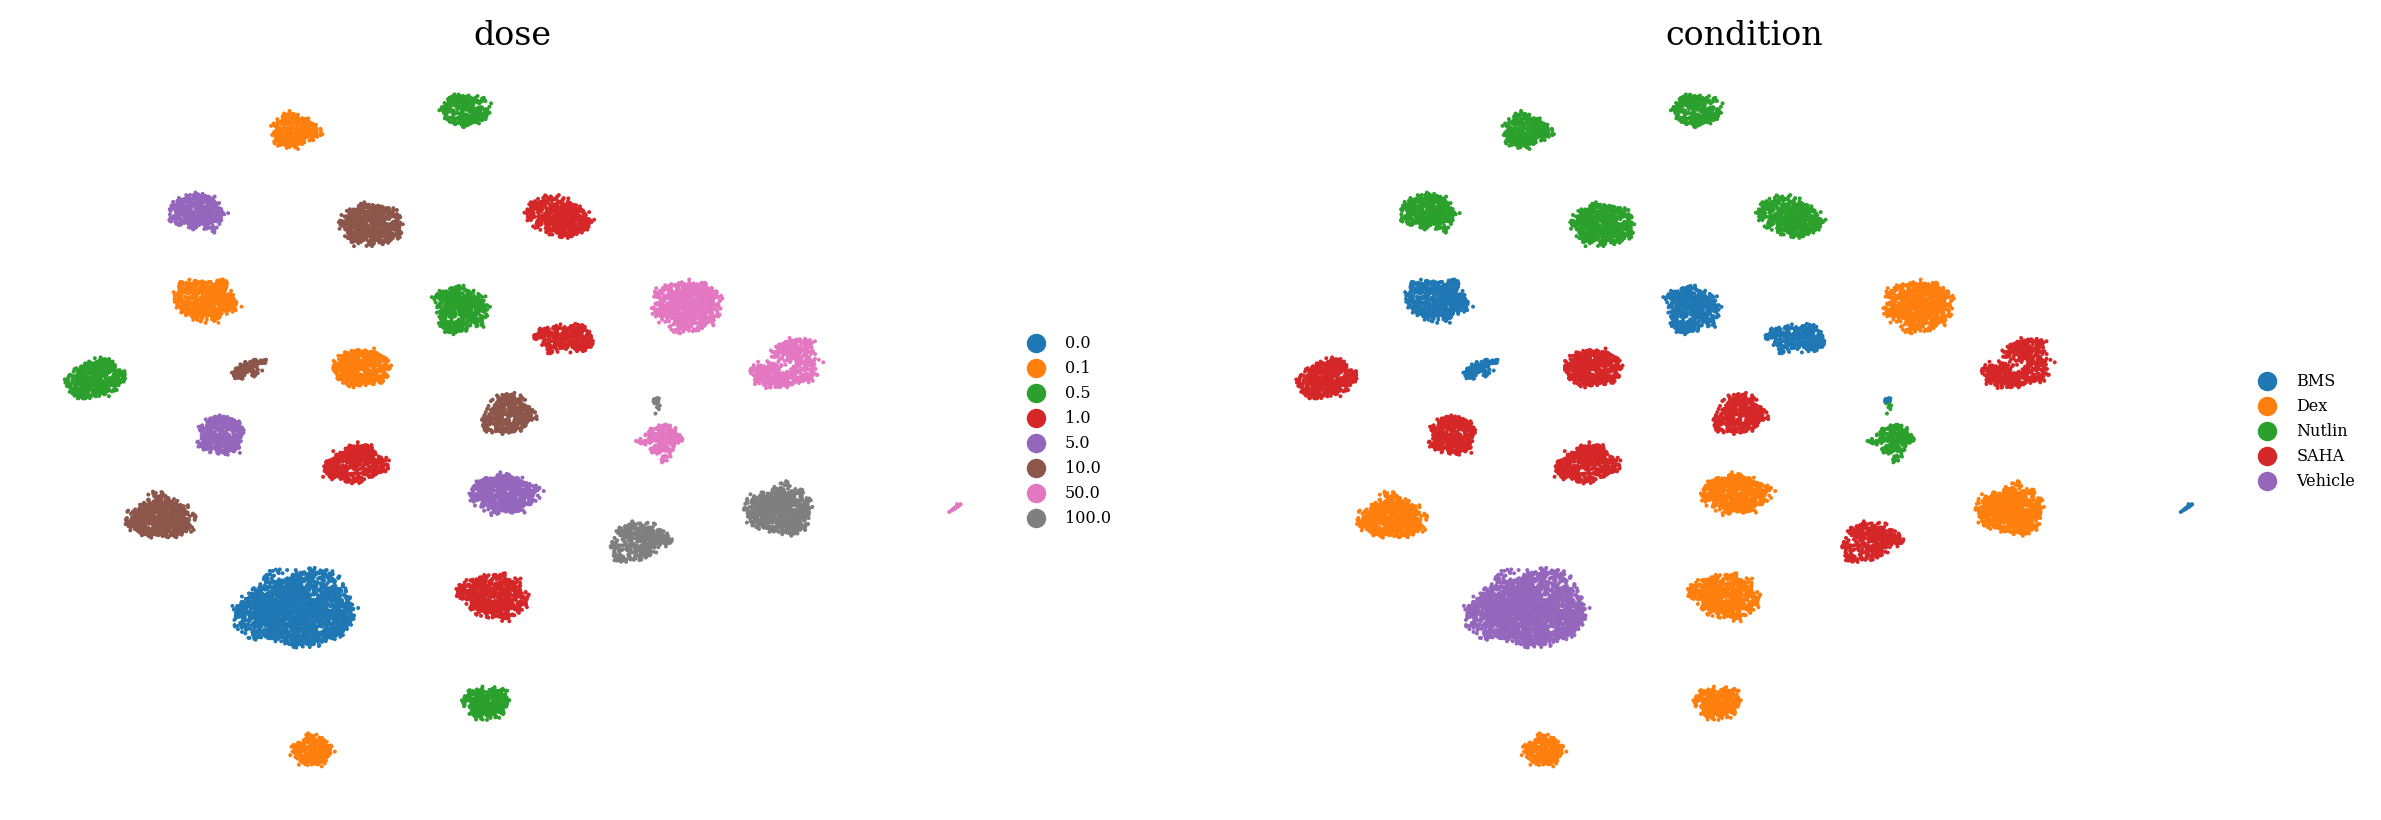

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

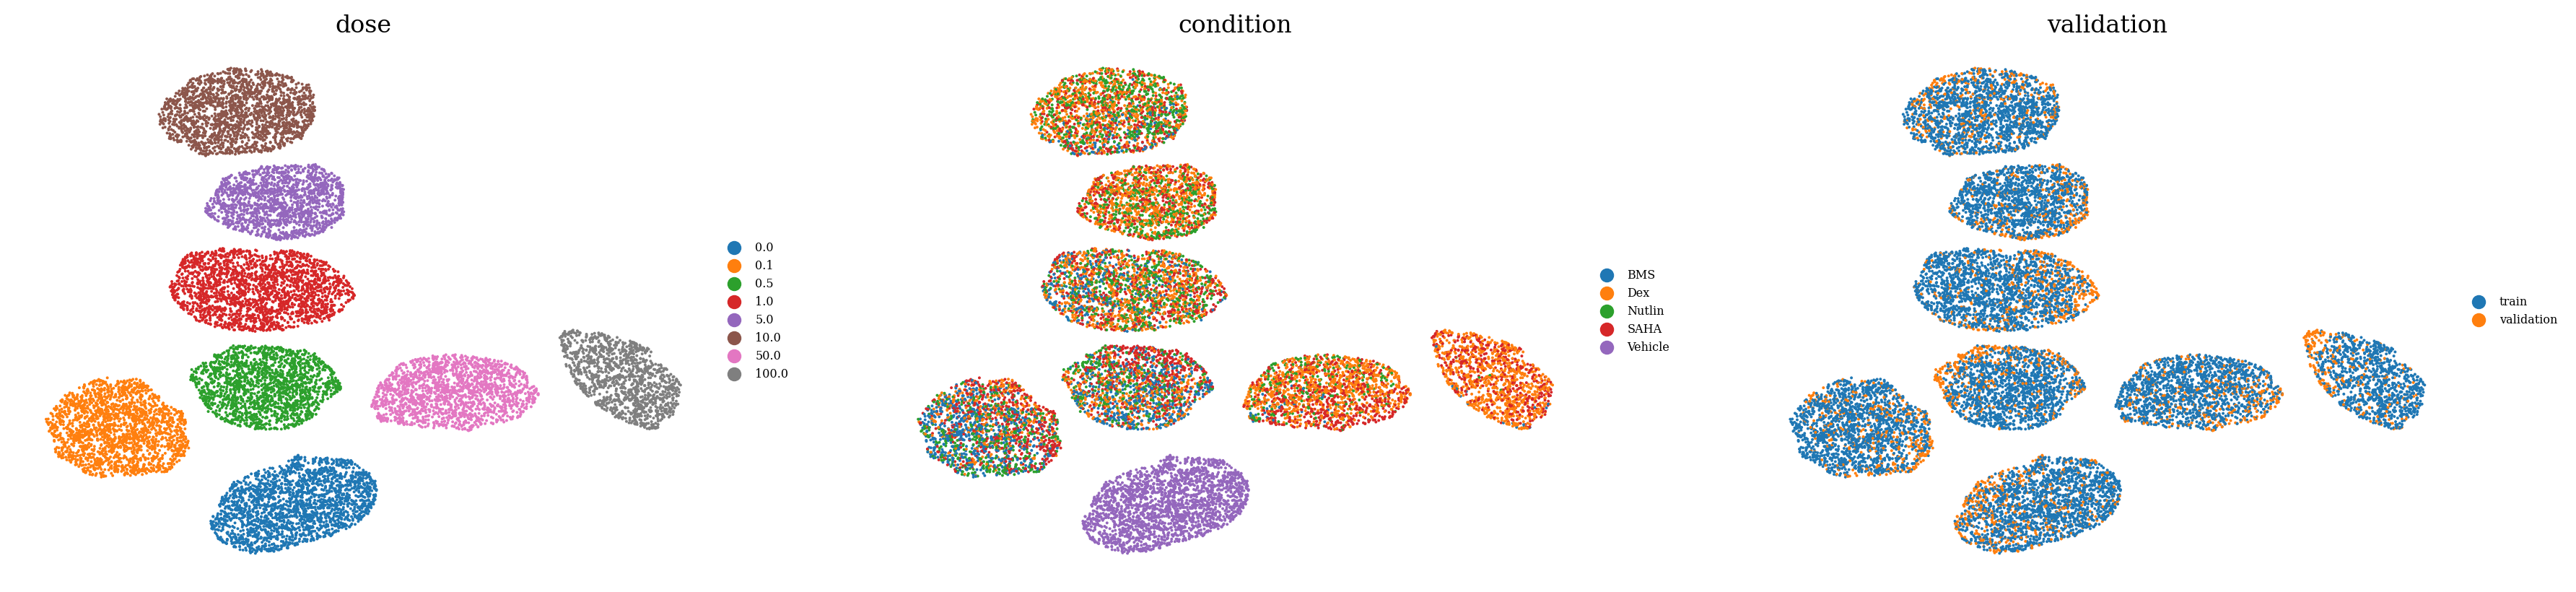

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

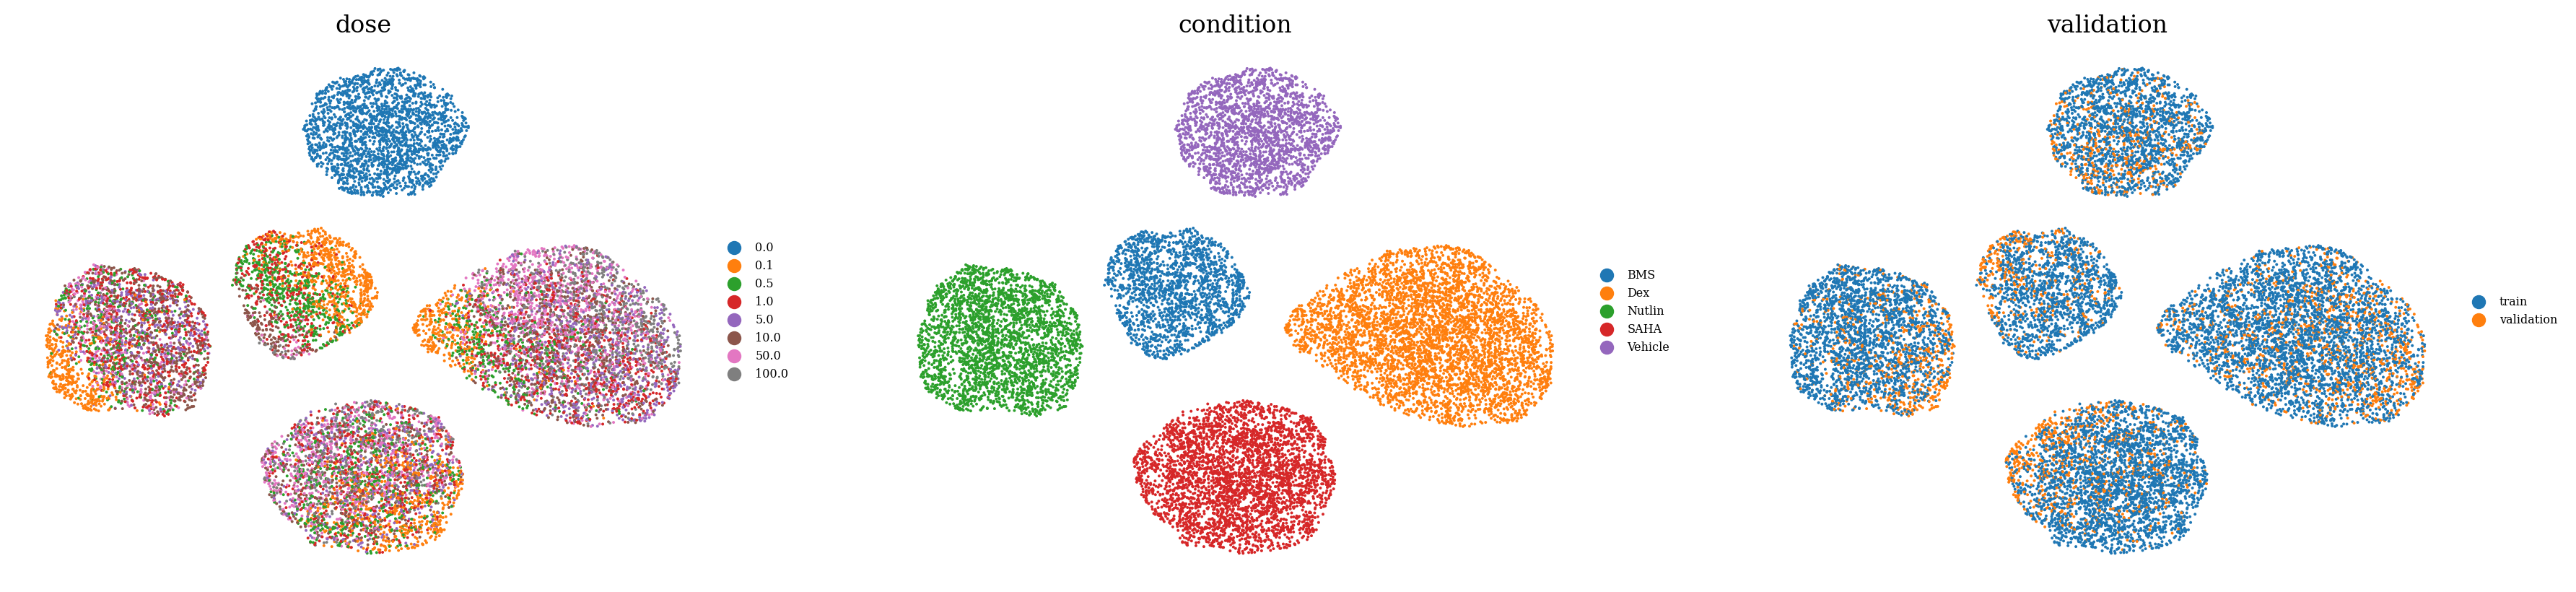

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )